# Madison Grades Predict

The goal of this project is to permit students, at the time of enrollment, to predict what sort of distribution of grades will be assigned for classes that they are considering taking.

In [1]:
# A cell to load the packages that I use in the notebook

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

### Step 1:

To begin with, I want to load in the raw data that I have available, and examine the available variables as well as which of the variables allow me to link together the various tables that I have. All of my data is currently located in the inputs folder, so that's where I'm going to start.

In [2]:
course_offerings = pd.read_csv('inputs/course_offerings.csv') # all courses offered from 2006
courses = pd.read_csv('inputs/courses.csv') # course names linked to course ids
grades = pd.read_csv('inputs/grade_distributions.csv')
instructors = pd.read_csv('inputs/instructors.csv')
classrooms = pd.read_csv('inputs/rooms.csv')
schedules = pd.read_csv('inputs/schedules.csv')
sections = pd.read_csv('inputs/sections.csv')
subject_mems = pd.read_csv('inputs/subject_memberships.csv')
subjects = pd.read_csv('inputs/subjects.csv')
teachings = pd.read_csv('inputs/teachings.csv')

Next, I'm going to systematically go through and look at these dataframes in order to see how they fit together and to determine what data might be useful.

In [3]:
course_offerings.head()

,uuid,course_uuid,term_code,name
0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,Cooperative Education Prog
2,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,Cooperative Education Prog
3,075da420-5f49-3dd0-93df-13e3c152e1b1,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1114,Cooperative Education Prog
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1104,Cooperative Education Prog


The dataframe ```course_offerings``` has four columns:
- ```uuid``` - a string which identifies the course. This is unique for each term the course is taught.
- ```course_uuid``` - a string which identifies the course. This is the same across all terms for the same course.
- ```term_code``` - an integer identifying the year and semester in which the class is taught
- ```name``` - a string containing the name of the class

It has the following links to my other dataframes:
- The column ```uuid``` in ```courses``` is the same as the column ```course_uuid``` in ```course_offerings```.
- The column ```course_offering_uuid``` in ```grades``` is the same as the column ```uuid``` in ```course_offerings```
- The column ```course_offering_uuid``` in ```sections``` is the same as the column ```uuid``` in ```course_offerings```
- The column ```course_offering_uuid``` in ```subject_mems``` is the same as the column ```uuid``` in ```course_offerings```

In [4]:
courses.tail()

,uuid,name,number
9301,4a7f3d9d-f2e5-3df2-8dee-2c2d02ed9098,Conservation Planning,972
9302,1220244c-2bbf-3169-8eb0-6a2da36f40f6,"Optimizing Value, Quality and Safety in Health...",973
9303,516f637c-a244-3df0-ba3f-f11ce650543d,Patient Education as a Strategy for Advocacy,974
9304,fbe0838f-9469-3d83-ad85-91ba5aabd1a3,Multidisciplinary Approaches to Colon Cancer P...,975
9305,1b17abd5-39f9-3a2c-8eda-a88bf1871221,Independent Study,998


The dataframe ```courses``` has three columns:
- ```uuid``` - a string which identifies the course. This is the same across all terms for the same course.
- ```name``` - a string containing the name of the course.
- ```number``` - an integer that is the course number assigned to the course. These are department dependant, and therefore are not unique across the university as a whole.

It has the following links to my other dataframes:
- The column ```uuid``` in ```courses``` is the same as the column ```course_uuid``` in ```course_offerings```.

In [5]:
grades.head()

,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,u_count,cr_count,n_count,p_count,i_count,nw_count,nr_count,other_count
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,158,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,139,12,2,0,3,0,0,0,0,0,0,0,0,0,0,0
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,87,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,70,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


The dataframe ```grades``` has eighteen columns:
- ```course_offering_uuid``` is a string which identifies the course section. This is unique to each section of the class.
- ```section_number``` is an integer that indicates which section of the class offered in a particular term is addressed here.
- ```a_count```, ```ab_count```, ```b_count```, ```bc_count```, ```c_count```, ```d_count```, and ```f_count``` contain integers indicating the number of students in a given course that received each of these grades. Together, these constitute the _graded students_.
- ```s_count```, ```u_count```, ```cr_count```, ```n_count```, ```p_count```, ```i_count```, ```nw_count```, ```nr_count```, and ```other_count``` contain integers indicating the number of students in a given course that received each of these grades. Together, these constitute the _ungraded students_.

It has the following links with other dataframes:
- The column ```course_offering_uuid``` in ```grades``` is the same as the column ```uuid``` in ```course_offerings```

In [6]:
instructors.head()

,id,name
0,761703,JOHN ARCHAMBAULT
1,3677061,STEPHANIE KANN
2,788586,KATHY PREM
3,1600463,KRISTIN KLARKOWSKI
4,693634,DAVID BOHNHOFF


The ```instructors``` dataframe contains only two columns:
- ```id``` is an integer that uniquely identifies each instructor
- ```name``` is a string giving the name of the instructor for each id

It has the following links with other dataframes:
- The column ```instructor_id``` in ```teachings``` is the same as the column ```id``` in ```instructors```


In [7]:
classrooms.head()

,uuid,facility_code,room_code
0,04368a56-c959-3e4b-8b3d-f4cc3538fea5,OFF CAMPUS,NaN
1,2cc50da3-ef0e-3572-a557-ca44930a0688,0032,0249
2,ebbf62b4-2ac3-356b-b0fa-7897f4446a17,0032,B101
3,ed828265-475b-31b4-b9a8-daec2a600449,0032,0549
4,b277dc8e-bab1-3a12-bc17-48d4a364d297,0032,0349


The dataframe ```classrooms``` has three columns:
- ```uuid``` is a string that uniquely identifies a classroom at the University of Wisconsin Madison
- ```facility_code``` is a string that identifies the building in which the room is located
- ```room_code``` is a string that identifies the number of the room in the given building

It has the following links with other dataframes:
- The column ```room_uuid``` in ```sections``` is the same as the column ```uuid``` in ```classrooms```



In [8]:
schedules.head()

,uuid,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun
0,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1,-1,False,False,False,False,False,False,False
1,875542a2-f786-34dd-933b-84a8af1aaaba,530,580,True,False,True,False,False,False,False
2,f41f1e4d-cb4f-3ded-b4b0-4a7c4da044e5,660,710,False,True,False,True,False,False,False
3,46da55a4-17f7-31a1-9492-fddb5af9cf13,800,850,False,True,False,True,False,False,False
4,8c7cd81e-4f81-357c-a40b-43f954484804,725,775,False,True,False,True,False,False,False


The dataframe ```schedules``` has ten columns:
- ```uuid``` is a string that identifies a schedule slot
- ```start_time``` is an integer that identifies the beginning of the class in minutes after midnight
- ```end_time``` is an integer that identifies the end of the class, also in minutes after midnight
- ```mon```, ```tues```, ```wed```, ```thurs```, ```fri```, ```sat```, ```sun``` are booleans that indicate whether a particular schedule slot meets on a given day

It has the following links with other dataframes:
- The column ```schedule_uuid``` in ```sections``` is the same as the column ```uuid``` in ```schedules```

In [9]:
sections.head()

,uuid,course_offering_uuid,section_type,number,room_uuid,schedule_uuid
0,45adf63c-48c9-3659-8561-07556d2d4ddf,344b3ebe-da7e-314c-83ed-9425269695fd,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
1,c6280e23-5e43-3859-893e-540d94993529,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
2,9395dc21-15d1-3fab-8d1f-6f3fe6114c48,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,04368a56-c959-3e4b-8b3d-f4cc3538fea5,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
3,b99e440b-39db-350a-81eb-b6eb1bd8b0bc,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
4,ca1c841f-41d5-3298-bd25-01c65751f150,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90


The dataframe ```sections``` has six columns:
- ```uuid``` is a string that identifies the section of a given course in a given semester
- ```course_offering_uuid``` is a string that identifies the course and semester in which it was taught.
- ```section_type``` is a string indicating the type of section (FLD, LEC, etc) 
- ```number``` is an integer indicating the section number for the particular section in the term in which it is taught (that is, if multiple sections of a particular course are taught in a given term, it allows us to distinguish them).
- ```room_uuid``` is a string indicating the room assigned for a given section
- ```schedule_uuid``` is a string indicating the schedule for a given section

It has the following links with other dataframes:
- The column ```course_offering_uuid``` in ```sections``` is the same as the column ```uuid``` in ```course_offerings```
- The column ```room_uuid``` in ```sections``` is the same as the column ```uuid``` in ```classrooms```
- The column ```schedule_uuid``` in ```sections``` is the same as the column ```uuid``` in ```schedules```
- The column ```section_id``` in ```teachings``` is the same as the column ```uuid``` in ```sections```

In [10]:
subject_mems.head()

,subject_code,course_offering_uuid
0,220,344b3ebe-da7e-314c-83ed-9425269695fd
1,320,344b3ebe-da7e-314c-83ed-9425269695fd
2,346,344b3ebe-da7e-314c-83ed-9425269695fd
3,612,344b3ebe-da7e-314c-83ed-9425269695fd
4,636,344b3ebe-da7e-314c-83ed-9425269695fd


The dataframe ```subject_mems``` has two columns:
- ```subject_code``` is an integer that identifies the subject for a given course offering. Note that a single course may have multiple subjects/be assigned to multiple departments
- ```course_offering_uiud``` is a string that identifies the course and the semester in which it was taught

It has the following links with other dataframes:
- The column ```course_offering_uuid``` in ```subject_mems``` is the same as the column ```uuid``` in ```course_offerings```
- The column ```subject_code``` in ```subject_mems``` is the same as the column ```code``` in ```subjects```

In [11]:
subjects.head()

,code,name,abbreviation
0,908,Soil Science,SOIL SCI
1,350,ENGLISH,ENGLISH
2,351,English as a Second Language,ESL
3,230,Human Development and Family Studies,HDFS
4,352,English,ENGL


The dataframe ```subjects``` has three columns:
- ```code``` is a integer that identifies each subject taught
- ```name``` is a string describing the subject
- ```abbreviation``` is a string with the abbreviation for the subject name

It has the following links with other dataframes:
- The column ```subject_code``` in ```subject_mems``` is the same as the column ```code``` in ```subjects```

In [12]:
teachings.head()

,instructor_id,section_uuid
0,761703,45adf63c-48c9-3659-8561-07556d2d4ddf
1,761703,c6280e23-5e43-3859-893e-540d94993529
2,761703,9395dc21-15d1-3fab-8d1f-6f3fe6114c48
3,3677061,b99e440b-39db-350a-81eb-b6eb1bd8b0bc
4,761703,ca1c841f-41d5-3298-bd25-01c65751f150


The dataframe ```teachings``` has two columns:
- ```instructor_id``` is an integer that codes the instructor for a given section
- ```section_uuid``` is a string that codes the section

It has the following links with other dataframes:
- The column ```instructor_id``` in ```teachings``` is the same as the column ```id``` in ```instructors```
- The column ```section_id``` in ```teachings``` is the same as the column ```uuid``` in ```sections```

For a diagram that depicts this clearly, [see here](
https://www.draw.io?lightbox=1&highlight=0000ff&edit=_blank&layers=1&nav=1&title=Untitled%20Diagram.drawio#R7V1bk5s4Fv41%2FZgpxJ3H6e7p3a0ku6lkam4vXdjINhmMXBin2%2FPrV2BhYySMDAjJ3XKnUkZgLuI7n85NR3fWw%2Fr1X1m4WX1GEUzuTCN6vbMe70wzcHz8f9GwPzRYLmlYZnF0aAKnhm%2FxP5A0GqR1F0dwe3ZgjlCSx5vzxjlKUzjPz9rCLEMv54ctUHJ%2B1U24hFTDt3mY0K2%2Fx1G%2BIq3AME47%2Fg3j5Ypc2nfIjnVYHUwatqswQi%2B1JuuXO%2BshQyg%2FfFu%2FPsCk6LuqXw6%2Fe2rZe7yxDKY5zw8238FfL799%2FuK%2FfliCv%2FL%2F7n77n%2F%2BBnOVHmOzIA8%2FRLtvCZ7RYwCxOl1ty8%2Fm%2B6pHtS7xOwhRv3S9Qmn8jewy8PV%2FFSfQp3KNdcUfbPJz%2FXW3dr1AW%2F4OPDxO8C%2BAGvDvLyQs33eJscZI8oARl5XUsaBR%2FZ7%2F8VpyRXCuDW%2FzbL9Xjg0bT5%2FD17MBP4Tav7hIlSbjZxrPyvosfrsNsGaf3KM%2FRmhxUPeXT%2BU0tyg%2FeHybxMsVtc3wtmFV9cXgaYONt0rEwy%2BFr6xsDRxxg%2BYFoDfNsjw8hP6igREQH2PZh%2B6UGRJccs6ph8HhgSMC%2FPJ76hA%2F8hUDkCriYFFx2WD5piKzCTfEVP2oeh8lXLJhhuiz23udoQ3o4gYvqjWTk3ovvs%2BotgFovH469L3ozxrL5M2lex1FUnrUBnYU%2Fh%2FN58RY34RyD%2BNPhUpZ9avpKLlk0IXzeRVLK5gqfEabFLaE8zMPZEdobFKd52Z3OPf6He%2F3B%2BMm5c%2FDlHvA2OG3jf8XhWf6A0m2ehXH5siHG3wssMHgfZWjzK0YcrB65LkZOA0pmKSkZ%2BhvWnm%2FmO7Zj8IKsXfBp5BGoYXnkQpplCAKaRQHty8fBMJvVBbwOmRSVdMaLtnNUjQaqLtwUj0nkoomQVhyQYZFc8zQYdeLDZOOjBghrSjzYbeOUOP4xuhFRnoyFpBviHR4UDWQTh5NNKtYZHT0OhR7ZXHJAznsgErsXkQiDgktBAatv6%2Bc5tls0jahNI74pmUY8TSPSaMRVi0Z8CgppuNYMojiDAMOXTCGBphBpFOKrRSGVh3NMLGj%2BEMsfFq8HTpQdDGiHrSaQqQgEGGx0dDCIODDQ7tiDV0Q77eU57c2g4bWvIkU1lBwhcQYTy2%2FHCbncSZZP12tcLqAv53EMa2GCeyQNc3iPdmm0pbB5fNABcKWdulK9d8zoAXPccw2Fx70LgYMB42CL%2F7c9PsDEtDB%2FMKAdwtcFCOpdBwSNjO8qYHCQ7ouDY%2BUHngYhtNO3GdoWGDwYP3h5qxwkJHh5mZ0Y8YaJ2Yn2Mj9pdpLKTo5i7ET7km%2FBgag0CU2h%2BPic1CLOa0R7ngeDRjsAeMHh9WIRYWAwaYsq3a1n2LTVPKI2j4DKdyONSEzaglJNQ3k%2FxGL2M56EgcOiFdhlFkbasSjTsXju6LMMRlZVwGIQzxSFElqJbZjYxMLGd2q9hsduUMXXp41tHm6yWlIvLqQKs2AoLlWY1ogLV%2BCDtrilDmlWP11ZGEyqMO0lfSeJD7pqKUXVdB8wyrv%2BtcTTB0C9fYt%2B%2BxbjTSfhDCZf0DbOY1ScnxDhlQgYT7%2FtYAVWyi%2BLFS6EvIbli9Nx8i2GMe67Z%2BUsJEzTj6D4u61h6NKw45YfcmSt%2FfARCTyXkaHB1IpEqc62Ociu0nbUkEHHblGhZdlRNh2ECp%2BxjowfQh3%2Beacemg4iYeRRTEwktA2umkL7joilX%2FxIHDhoz28408xyE8wCAK%2FnRhh6tO9XIWpRzPdr03MUNLPcCLNUxoc0ZnE4vCyaWaZilkAtZnFopWU219RyG9TiMqbOTUstWmlRh1ocxZQWh1HISjPLbTBLINtl6wxz2WpmGZVZFHPhurTSEmlmuQlmOYJOGrO4WmdRh1lcxXQWm06fWmhmuQ1msaW7cIfNA9DMMqqjRbF5AS7NLP8pumk3z1Gmc3jl5fBaJB%2BgSlYxAppGWPVEAlMUUmgaUXFK7AK6b7meb%2BQFM8MYNGC5LRSkSkFfl44q6Yq%2B06q%2F%2FepfCUOER4eKbmEKrNKkM4ru20El0qv5eroGljwW8frVwBIHhmFZcppBJDAIbyFfYYXTPF3JVyKD9CvlKw4MtAk0T8LtNkNorW1libYyODeWHYfhzWfSBhA1q8ijjRglS0hFDvQjm%2BITpQeea%2Bxl35xZ5fSi%2FkOU12INqWIv%2B7R1pO3lacep7uy5Se1lnzZ7FrjPkzjf6%2BUrlFB7OzhFuuFc6d1a7ZVRfb47r2XaFSzovJZC49VUcgtUIn0pHH9YYoumkkFU0p3IMi2VCHCnaAYRyyDcS%2BEI87v4upKlRArpzliZ1Ann056V7XwFo12ia87JXIG6YoRjrr7FxxqWIQopAe0YUdMHF0J%2F8YZzVty5D2eLQUOU3%2BJhUcUHF9AeF%2B2Dm3SYCvpFm8UhgvaglIPIcx7rzBX5Om8HoUh3wAW0z0U2nbwflfcgu%2BpYzQHtQoFppJnkFphEuv8t0EvaS2QSxda0B4z1htYo1SyiOIvIX44aMNYh0jwy2XIyQLFV7QFjQZl8x%2FLAaSZRi0l4F6YWCB0dEZTIJBwLyEysktDRnRcoyEuriWQ8IqlIQ6JKQoeCNJFMp5L0myUocFyhLd18tWPNYtdUohaVMNbKnFonETA5TFMJt07SXTN9YiqhQ8eLLNZEojiRmIy1MqcmEj3lWCaRKDbnGADa1t2Gylft0kRiyfe36riNTONGscBNQOun252O2yjPI6xF5qYN%2F%2BqwjcTwr2JRm0BAIr2mEMEUwlpebtLpF4F2s0qkkH5eVmFgACY9oJD1cvX0C3nTL8yqCkTFGj5twJgGCyiBqBIowKRHG3HzLzhGnPaaoQuTUTNU6dLVV9UMdWeuM6wGCpH6ayZgMNEmLN0emEOrhk5R5%2Fpdzcgg8n9x6GLVuhaHEYtRvwvtsi18RosFzHD3P6tJUP4cvmWCmvmO7RhCCYoxoWNigrJognr6CDRDyWQoSzWGsum4Y1lqRUlaaqkd92ZoaYTacV20xEh8mJiWbDpe%2BfTxKvte09LYtGR3RzEnVpxoWqpqLgikpvGn1L8ZahphSn0XNbHWnp9aZWJxk6W5SarKpBo3VQuZ0%2F7I53y%2FUX6CrNKUNEp8o5NoGCukMYlGXK6FPWy2vV4ibVz1x%2BxFMeLgYdEUk%2B7WM5gpRC5YKXi8L%2F5ulmFoJaf8kCNr7YePWE7yTNmcZOkKIDLVHNU4yGYkku5m3%2FHT6bCrxKp31nnY1fF4a2UKW3kC2HTiqLhKzQNsdAgiB3oUoSid8HONjR64nhUOdB%2FaLWmoqtS9O%2BruuvCdPHW53%2BQpgZigM4T0co1KWOIddCK96h0YuFa5VnqHMUm%2FUs8C4UDHzMPZLIM%2F4rBw8GlGUZ1RpFe%2FAw4dutKMMh2j9FsZSyAcBHhVNIsIZhH5K1AAR9eskkgjTr%2BaVQLhQPtYiDfueQ31WrAKTYRwq9lLdU%2B%2ByQCLL27MYc3dPYBF6hJqVzrmlI4jTe2Yc1qcLhfmQ7BAJ84J49BOmMIx96BzjmWPZd1zgqdNoHFkzooYED%2FQsyIG0xRrVsTENMWetvWgc5Bl05RqUyNck0JKDkOsPadLrW%2FL07e9c3XbqwDQZaqLU7dd2sUTFxK1m%2Bcoe1ZwHg0eZd23PJBFXjAzBg5kB%2BlXOBDu0g4irW%2BrMJC53b6jiQcyhu%2BIJKyrqWfr8ghD6Yk3sC4QdOw8Ha1nS6en7uydaenJCyhAwGgJq7cOkxl6%2BeXUgDt7l0YwIl2N%2B3WFligNk0%2BoxEbRjd9hnu9JP4a7HBX6cr6udGz4Gud%2FkJ8X3%2F8svv%2FkkK3H19qux32l%2BRZ6%2Bc9ZVr73KmpWtBWqcPWDNGocgVtq%2Bw%2BPWTxbL2HHPYR22RzyUH1eEdTVMMhgEubxj%2FNbFPDSOaoEnqEgzeN8%2F7W8OZTW4dAUmfqLpl4I6zXiU2f7Ix6KjRogis0TIsqtfQ0ff9QgxQOjc0A0AdSqprcquIc9vxPRtfhABjjR5PrcYOpWeQCzFlTVyI06co0vBcGebELQDME0yOrwqORHJ%2BjS5zHPT%2BQ3T3ToCupEpQwcn3uIWHCko9XF4sR%2B44rE6NAuWRx%2Fr8beutyB6%2BSuVVts1bOESsmx6lh%2Fzp1MTBqhSq95Cl45CRpi4jTO0yImGGXhvnYYUZNa79dpiKNFlJC222oe73ccb1oXj8dfDnc8roxXL0EPfReGvmOopTVIIVSoTV6R5ijoI1akG6LoGT1F%2BnhDR1ngk%2BnxxIJjHQstFjciFhzBHKFiYTbQ7IG%2BYtFQLX17arGgo1BSNMKeypoWCXKc1T3VQaxEgJF0P8pG4lT%2BxpMIjozqqQaKd4FuiaBtYM1rKiW8oG1aLMCb2LD3OdK537t2c6qh1lp9TKwlz1FqSijcXaeBUsPpB3fHPT%2BRaTkTw51jLakptZaeUL8mQnAd1I%2BVTFtrgAqFehVz6dbkOUpDak2eTyY4Vny9Td9uTylrnQXQmj8vlv6rsCeHUEh25I6mzDc9pm5zBtNYntxmhIaspC7Y03plkFE12%2FkqS8Ep%2FpjKU1XVjJaePuPcqAoXr%2FVst%2BSETiZwDYXKchpywm2INEMa1bSZkQWuGdqwPevyfTWOt%2Fyz468VULyZIZTXD8%2FCzeozimBxxP8B)

### Step 2

Determine which data we want to use. It should have the following characteristics:
1. It should be available to the students at the time that they register.
2. It should be available for a significant fraction of the courses.
3. It should have a plausible explanation for how it might impact the grade distributions.

To begin with, I want to know something about length and missing values for each of these dataframes.

For the ```course_offerings``` dataframe, 

In [13]:
print('The number of entries in the course_offerings df is ', len(course_offerings))
course_offerings.isna().sum()

The number of entries in the course_offerings df is  81452


uuid              0
course_uuid       0
term_code         0
name           2536
dtype: int64

So for the ```course_offerings``` dataframe, I'm missing only data on names of courses, where I'm missing roughly 3% of the data.

In [14]:
print('The number of entries in the courses df is ', len(courses))
courses.isna().sum()

The number of entries in the courses df is  9306


uuid       0
name      42
number     0
dtype: int64

In [15]:
print('The number of entries in the instructors df is ', len(instructors))
instructors.isna().sum()

The number of entries in the instructors df is  18737


id      0
name    1
dtype: int64

In [16]:
print('The number of entries in the classrooms df is ', len(classrooms))
classrooms.isna().sum()

The number of entries in the classrooms df is  1350


uuid             0
facility_code    0
room_code        2
dtype: int64

In [17]:
print('The number of entries in the schedules df is ', len(schedules))
schedules.isna().sum()

The number of entries in the schedules df is  4467


uuid          0
start_time    0
end_time      0
mon           0
tues          0
wed           0
thurs         0
fri           0
sat           0
sun           0
dtype: int64

In [18]:
print('The number of entries in the sections df is ', len(sections))
sections.isna().sum()

The number of entries in the sections df is  315602


uuid                         0
course_offering_uuid         0
section_type                 0
number                       0
room_uuid               105958
schedule_uuid                0
dtype: int64

In [19]:
print('The number of entries in the subject_mems df is ', len(subject_mems))
subject_mems.isna().sum()

The number of entries in the subject_mems df is  95314


subject_code            0
course_offering_uuid    0
dtype: int64

In [20]:
print('The number of entries in the subjects df is ', len(subjects))
subjects.isna().sum()

The number of entries in the subjects df is  200


code            0
name            0
abbreviation    0
dtype: int64

In [21]:
print('The number of entries in the teachings df is ', len(teachings))
teachings.isna().sum()

The number of entries in the teachings df is  315211


instructor_id    0
section_uuid     0
dtype: int64

In [22]:
print('The number of entries in the grades df is ', len(grades))
grades.isna().sum()

The number of entries in the grades df is  193262


course_offering_uuid    0
section_number          0
a_count                 0
ab_count                0
b_count                 0
bc_count                0
c_count                 0
d_count                 0
f_count                 0
s_count                 0
u_count                 0
cr_count                0
n_count                 0
p_count                 0
i_count                 0
nw_count                0
nr_count                0
other_count             0
dtype: int64

Looking at all of my dataframes, I can see that the column for which I'm missing the most data (and the only one for which the missing data seems likely to be a major problem) is the ```sections``` dataframe, in which fully a third of the classroom assignments are not given. This could indicate a number of things, some of which would be considerably more problematic than others. It does seem, however, that it may be more difficult than I had anticipated to use assigned classroom size as a proxy for class size.

Let's investigate this problem a bit further.

In [23]:
sections.head(10)

,uuid,course_offering_uuid,section_type,number,room_uuid,schedule_uuid
0,45adf63c-48c9-3659-8561-07556d2d4ddf,344b3ebe-da7e-314c-83ed-9425269695fd,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
1,c6280e23-5e43-3859-893e-540d94993529,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
2,9395dc21-15d1-3fab-8d1f-6f3fe6114c48,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,04368a56-c959-3e4b-8b3d-f4cc3538fea5,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
3,b99e440b-39db-350a-81eb-b6eb1bd8b0bc,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
4,ca1c841f-41d5-3298-bd25-01c65751f150,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
5,da41b0aa-2b81-378f-914e-39f3465eed19,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,04368a56-c959-3e4b-8b3d-f4cc3538fea5,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
6,51c4dc00-1fc7-3c7c-98a1-eba112aa3e5d,075da420-5f49-3dd0-93df-13e3c152e1b1,FLD,1,04368a56-c959-3e4b-8b3d-f4cc3538fea5,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
7,53f95c0f-4ea9-374c-9285-ac41c30ff720,075da420-5f49-3dd0-93df-13e3c152e1b1,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
8,574d9b35-9c76-3380-8e83-bd883a078694,2b4e216d-a728-3713-8c7c-19afffc6b2fd,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90
9,8fc362a6-d94e-3ade-aee7-87796c567dcf,2b4e216d-a728-3713-8c7c-19afffc6b2fd,FLD,1,04368a56-c959-3e4b-8b3d-f4cc3538fea5,f2d66a4d-0c08-3b48-abf6-649fffd7ae90


So looking at the first ten rows of this dataframe, we see that, for example, rows 2-5 have the same ```course_offering_uuid``` and the same ```number```. We can also observe from above that the number of sections is 315602 (which is roughly equal to the number of teaching assignments), which the number of rows in the ```grades``` dataframe is only 193262, or rougly 2/3 of this value. One likely explanation for this is that there are many sections that are team taught, and that these account for the missing room information. One way to confirm this would be to create a dataframe that eliminates these duplicate sections and check whether the problems with room information are eliminated.

In [24]:
# Beginning by creating a dictionary

sections['section_info'] = sections['course_offering_uuid'] + ' * ' + sections['number'].astype('str')

rooms = defaultdict(list)

for i in range(len(sections)):
    rooms[sections.loc[i,'section_info']].append(sections.loc[i, 'room_uuid'])
    
for key in rooms.keys():
    rooms[key] = [room for room in list(set(rooms[key])) if str(room) != 'nan']
    if rooms[key] == []:
        rooms[key] = np.nan
    else:
        rooms[key] = rooms[key][0]

In [25]:
# And now I want to add this column to my sections dataframe

rooms_df = pd.DataFrame.from_dict(rooms, orient = 'index', columns = ['classroom_uuid'])

OK, so I think that what I want to do is to create a copy of ```sections```, and then I want to drop rows of duplicate ```section_info``` values. I should then be able to merge this with the ```rooms_df``` dataframe. But, I'm really not sure how to do this efficiently. 

In [26]:
sections_copy = sections.copy()
print("length sections_copy is", len(sections_copy))

sections_copy.drop_duplicates('section_info')
print("new length sections_copy is", len(sections_copy.drop_duplicates('section_info')))

length sections_copy is 315602
new length sections_copy is 277894


In [27]:
len(rooms_df)

277894

In [28]:
sections_copy.drop_duplicates('section_info', inplace = True)

sections_copy.head()

,uuid,course_offering_uuid,section_type,number,room_uuid,schedule_uuid,section_info
0,45adf63c-48c9-3659-8561-07556d2d4ddf,344b3ebe-da7e-314c-83ed-9425269695fd,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,344b3ebe-da7e-314c-83ed-9425269695fd * 1
1,c6280e23-5e43-3859-893e-540d94993529,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,f718e6cd-33f0-3c14-a9a6-834d9c3610a8 * 1
2,9395dc21-15d1-3fab-8d1f-6f3fe6114c48,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,04368a56-c959-3e4b-8b3d-f4cc3538fea5,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,ea3b717c-d66b-30dc-8b37-964d9688295f * 1
6,51c4dc00-1fc7-3c7c-98a1-eba112aa3e5d,075da420-5f49-3dd0-93df-13e3c152e1b1,FLD,1,04368a56-c959-3e4b-8b3d-f4cc3538fea5,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,075da420-5f49-3dd0-93df-13e3c152e1b1 * 1
8,574d9b35-9c76-3380-8e83-bd883a078694,2b4e216d-a728-3713-8c7c-19afffc6b2fd,FLD,1,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,2b4e216d-a728-3713-8c7c-19afffc6b2fd * 1


And now, I should (knock on wood) be able to join these to get a classroom assigned to each section.

In [29]:
rooms_df.head()

,classroom_uuid
344b3ebe-da7e-314c-83ed-9425269695fd * 1,NaN
f718e6cd-33f0-3c14-a9a6-834d9c3610a8 * 1,NaN
ea3b717c-d66b-30dc-8b37-964d9688295f * 1,04368a56-c959-3e4b-8b3d-f4cc3538fea5
075da420-5f49-3dd0-93df-13e3c152e1b1 * 1,04368a56-c959-3e4b-8b3d-f4cc3538fea5
2b4e216d-a728-3713-8c7c-19afffc6b2fd * 1,04368a56-c959-3e4b-8b3d-f4cc3538fea5


In [30]:
sections = pd.merge(sections_copy, rooms_df, left_on = 'section_info', right_index = True, how = 'inner')

In [31]:
sections.drop('room_uuid', axis = 1, inplace = True)

OK, so to the extent that it seems to be possible, I've got a classroom assigned for each section. And I think that I may be ready to go ahead and begin to build the big dataframe that combines everything that I've got, except for one thing. Since I want to use classroom size as a proxy for class size, I need to somehow determine the capacity of each of these classrooms, and I need to do so without going to the University of Wisconsin and counting the number of seats in each classroom. I think that the best way to do this is to 

1. Determine the enrollment for each class by adding up all of the grades
2. Use the sections dataframe to assign classrooms to each section
3. Create a dictionary (or something) with the total enrollments for each section taught in each classroom
4. Take the maximum, minimum, and median values for these figures

In [32]:
classes = grades.copy()

In [33]:
classes['section_info'] = classes['course_offering_uuid'] + ' * ' + classes['section_number'].astype('str')

classes['enrollment'] = (classes['a_count'] + classes['ab_count'] + classes['b_count'] + classes['bc_count'] +
                         classes['c_count'] + classes['d_count'] + classes['f_count'] + classes['s_count'] +
                         classes['u_count'] + classes['cr_count'] + classes['n_count'] + classes['p_count'] +
                         classes['i_count'] + classes['nw_count'] + classes['nr_count'] + classes['other_count'])

In [34]:
classes = classes[['section_info', 'enrollment']]

In [35]:
classroom_data = pd.merge(classes, sections, on = 'section_info', how = 'left')[['enrollment', 'classroom_uuid']]

classroom_data.head()

,enrollment,classroom_uuid
0,105,NaN
1,159,NaN
2,156,04368a56-c959-3e4b-8b3d-f4cc3538fea5
3,88,04368a56-c959-3e4b-8b3d-f4cc3538fea5
4,71,04368a56-c959-3e4b-8b3d-f4cc3538fea5


And now, I want to make this into a dictionary.

In [36]:
classroom_data_dict = defaultdict(list)

for i in range(len(classroom_data)):
    classroom_data_dict[classroom_data.loc[i, 'classroom_uuid']].append(classroom_data.loc[i, 'enrollment'])
    


In [37]:
for key in classroom_data_dict.keys():
    vals_to_use = [val for val in classroom_data_dict[key] if val != 0]
    try:
        max_val = max(vals_to_use)
        min_val = min(vals_to_use)
        med_val = np.median(vals_to_use)
        third_quart = np.percentile(vals_to_use, 75)
        count = len(vals_to_use)
    except:
        max_val = 0
        min_val = 0
        med_val = 0
        third_quart = 0
        count = 0
    classroom_data_dict[key] = [max_val, min_val, med_val, third_quart, count]
    

In [38]:
classroom_data = pd.DataFrame.from_dict(classroom_data_dict, orient = 'index')
classroom_data.columns = ['max_enrollment', 'min_enrollment', 'med_enrollment', 'third_quart', 'count']

classroom_data.head()

,max_enrollment,min_enrollment,med_enrollment,third_quart,count
NaN,486,1,10.0,16.0,11744
04368a56-c959-3e4b-8b3d-f4cc3538fea5,278,1,14.0,23.0,1018
ebbf62b4-2ac3-356b-b0fa-7897f4446a17,51,6,34.0,41.0,233
ed828265-475b-31b4-b9a8-daec2a600449,49,6,20.0,31.0,209
2cc50da3-ef0e-3572-a557-ca44930a0688,40,8,21.0,24.0,100


OK, so this is actually kind of interesting, because there seems to be a rather shocking amount of difference between the maximum and median enrollments for some of these classrooms. It's kind of inconceivable to me that they might assign classes of fewer than 20 students to a classroom that actually holds nearly 300, unless they have a rather shockingly large number of enormous classrooms. The zeros I can understand, maybe, but the 1 student? That's just bizarre.

In [39]:
classroom_data.drop(classroom_data.index.tolist()[0], axis = 0, inplace = True)

And now, I think that I really am ready to pull together the dataframe that I want. To begin with, I need:
1. The letter grade percentages for each section. 
2. A boolean column indicating whether or not there are any (letter) graded students.
3. The classroom assigned, assuming that there is one.
3. A boolean column indicating whether or not a classroom assignment is given.
4. The starting and ending times.
5. The class length.
6. The days on which the class met.
7. Boolean columns indicating whether start times and meeting days are given.
8. The course level.
9. The subject/department.

In [40]:
uw_section_grades = grades.copy()
uw_section_grades.head()

,course_offering_uuid,section_number,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,u_count,cr_count,n_count,p_count,i_count,nw_count,nr_count,other_count
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,158,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,139,12,2,0,3,0,0,0,0,0,0,0,0,0,0,0
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,87,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,70,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [41]:
uw_section_grades['students'] = uw_section_grades.drop(['course_offering_uuid', 'section_number'], axis = 1).sum(axis = 1)

In [42]:
# Adding the percentages for each grade, and 

grade_list = ['a', 'ab', 'b', 'bc', 'c', 'd', 'f']

for grade in grade_list:
    uw_section_grades[grade + '_perc'] = uw_section_grades[grade + '_count']/uw_section_grades['students']
    
grade_list.extend(['s', 'u', 'cr', 'n', 'p', 'i', 'nw', 'nr', 'other'])    

to_drop = [grade + '_count' for grade in grade_list]
uw_section_grades.drop(to_drop, axis = 1, inplace = True)

uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,159,0.993711,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,156,0.891026,0.076923,0.012821,0.0,0.019231,0.0,0.0
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,88,0.988636,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,71,0.985915,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [43]:
uw_section_grades['graded?'] = uw_section_grades.drop(['course_offering_uuid', 'section_number', 'students'], axis = 1).sum(axis = 1) > 0

In [44]:
uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,True
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,159,0.993711,0.000000,0.000000,0.0,0.000000,0.0,0.0,True
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,156,0.891026,0.076923,0.012821,0.0,0.019231,0.0,0.0,True
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,88,0.988636,0.000000,0.000000,0.0,0.000000,0.0,0.0,True
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,71,0.985915,0.000000,0.000000,0.0,0.000000,0.0,0.0,True


Next, I want to add the classroom assignment, but for this I first need to add the ```section_info``` column, which is just the concatenation of ```course_offering_uuid``` and ```section_number```.

In [45]:
uw_section_grades['section_info'] = uw_section_grades['course_offering_uuid'] + ' * ' + uw_section_grades['section_number'].astype('str')

In [46]:
sections.head()

,uuid,course_offering_uuid,section_type,number,schedule_uuid,section_info,classroom_uuid
0,45adf63c-48c9-3659-8561-07556d2d4ddf,344b3ebe-da7e-314c-83ed-9425269695fd,FLD,1,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,344b3ebe-da7e-314c-83ed-9425269695fd * 1,NaN
1,c6280e23-5e43-3859-893e-540d94993529,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,FLD,1,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,f718e6cd-33f0-3c14-a9a6-834d9c3610a8 * 1,NaN
2,9395dc21-15d1-3fab-8d1f-6f3fe6114c48,ea3b717c-d66b-30dc-8b37-964d9688295f,FLD,1,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,ea3b717c-d66b-30dc-8b37-964d9688295f * 1,04368a56-c959-3e4b-8b3d-f4cc3538fea5
6,51c4dc00-1fc7-3c7c-98a1-eba112aa3e5d,075da420-5f49-3dd0-93df-13e3c152e1b1,FLD,1,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,075da420-5f49-3dd0-93df-13e3c152e1b1 * 1,04368a56-c959-3e4b-8b3d-f4cc3538fea5
8,574d9b35-9c76-3380-8e83-bd883a078694,2b4e216d-a728-3713-8c7c-19afffc6b2fd,FLD,1,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,2b4e216d-a728-3713-8c7c-19afffc6b2fd * 1,04368a56-c959-3e4b-8b3d-f4cc3538fea5


In [47]:
# And adding the classroom info from the sections dataframe

uw_section_grades = pd.merge(uw_section_grades, sections[['section_type', 'schedule_uuid',
                                                          'section_info', 'classroom_uuid']], 
         left_on = 'section_info', right_on = 'section_info', how = 'left')

uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_info,section_type,schedule_uuid,classroom_uuid
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,NaN
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,159,0.993711,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,f718e6cd-33f0-3c14-a9a6-834d9c3610a8 * 1,FLD,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,NaN
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,156,0.891026,0.076923,0.012821,0.0,0.019231,0.0,0.0,True,ea3b717c-d66b-30dc-8b37-964d9688295f * 1,FLD,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,04368a56-c959-3e4b-8b3d-f4cc3538fea5
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,88,0.988636,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,075da420-5f49-3dd0-93df-13e3c152e1b1 * 1,FLD,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,04368a56-c959-3e4b-8b3d-f4cc3538fea5
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,71,0.985915,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,2b4e216d-a728-3713-8c7c-19afffc6b2fd * 1,FLD,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,04368a56-c959-3e4b-8b3d-f4cc3538fea5


In [48]:
uw_section_grades['classroom?'] = uw_section_grades['classroom_uuid'].notnull()

uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_info,section_type,schedule_uuid,classroom_uuid,classroom?
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,NaN,False
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,159,0.993711,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,f718e6cd-33f0-3c14-a9a6-834d9c3610a8 * 1,FLD,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,NaN,False
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,156,0.891026,0.076923,0.012821,0.0,0.019231,0.0,0.0,True,ea3b717c-d66b-30dc-8b37-964d9688295f * 1,FLD,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,88,0.988636,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,075da420-5f49-3dd0-93df-13e3c152e1b1 * 1,FLD,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,71,0.985915,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,2b4e216d-a728-3713-8c7c-19afffc6b2fd * 1,FLD,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True


In [49]:
len(uw_section_grades)

193262

In [50]:
uw_section_grades = pd.merge(uw_section_grades, schedules, left_on = 'schedule_uuid', right_on = 'uuid', how = 'left')

uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,...,uuid,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1.0,-1.0,False,False,False,False,False,False,False
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,159,0.993711,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1.0,-1.0,False,False,False,False,False,False,False
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,156,0.891026,0.076923,0.012821,0.0,0.019231,0.0,0.0,...,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1.0,-1.0,False,False,False,False,False,False,False
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,88,0.988636,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1.0,-1.0,False,False,False,False,False,False,False
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,71,0.985915,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1.0,-1.0,False,False,False,False,False,False,False


In [51]:
uw_section_grades.drop(['uuid', 'schedule_uuid'], axis = 1, inplace = True)

pd.options.display.max_columns = 50

uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_info,section_type,classroom_uuid,classroom?,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,159,0.993711,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,f718e6cd-33f0-3c14-a9a6-834d9c3610a8 * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,156,0.891026,0.076923,0.012821,0.0,0.019231,0.0,0.0,True,ea3b717c-d66b-30dc-8b37-964d9688295f * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,88,0.988636,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,075da420-5f49-3dd0-93df-13e3c152e1b1 * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,71,0.985915,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,2b4e216d-a728-3713-8c7c-19afffc6b2fd * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False


In [52]:
uw_section_grades['time_assigned?'] = uw_section_grades['start_time'] != -1.0

In [53]:
uw_section_grades['class_length'] = uw_section_grades['end_time'] - uw_section_grades['start_time']

In [54]:
uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_info,section_type,classroom_uuid,classroom?,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun,time_assigned?,class_length
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,159,0.993711,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,f718e6cd-33f0-3c14-a9a6-834d9c3610a8 * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,156,0.891026,0.076923,0.012821,0.0,0.019231,0.0,0.0,True,ea3b717c-d66b-30dc-8b37-964d9688295f * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,88,0.988636,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,075da420-5f49-3dd0-93df-13e3c152e1b1 * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,71,0.985915,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,2b4e216d-a728-3713-8c7c-19afffc6b2fd * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0


In [55]:
uw_section_grades['days_assigned?'] = uw_section_grades[['mon', 'tues', 'wed', 'thurs',
                                                         'fri', 'sat', 'sun']].sum(axis = 1) > 0

In [56]:
uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_info,section_type,classroom_uuid,classroom?,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun,time_assigned?,class_length,days_assigned?
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,159,0.993711,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,f718e6cd-33f0-3c14-a9a6-834d9c3610a8 * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,156,0.891026,0.076923,0.012821,0.0,0.019231,0.0,0.0,True,ea3b717c-d66b-30dc-8b37-964d9688295f * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,88,0.988636,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,075da420-5f49-3dd0-93df-13e3c152e1b1 * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,71,0.985915,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,2b4e216d-a728-3713-8c7c-19afffc6b2fd * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False


In [57]:
courses.head()

,uuid,name,number
0,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,Cooperative Education Program,1
1,c070a84f-648f-351d-9499-5d0e30ad02cc,Cooperative Education/Co-op in Life Sciences C...,1
2,e6b4b7ae-0e0b-3aa5-9d77-7fcd90c9cfa3,Cooperative Education Program,1
3,8f63bde1-ff7f-3fe7-9901-862908bf134c,Workshop in Dance Activity,1
4,f3541888-584a-3923-9ce7-6341ff3d84a1,Cooperative Education/Co-op in Agricultural & ...,1


In [58]:
course_offerings.head()

,uuid,course_uuid,term_code,name
0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,Cooperative Education Prog
2,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,Cooperative Education Prog
3,075da420-5f49-3dd0-93df-13e3c152e1b1,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1114,Cooperative Education Prog
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1104,Cooperative Education Prog


So before I try to add course infomation to my dataframe, I'm going to pull together ```courses```, ```course_offerings```, ```subjects```, and ```subject_mems```. 

In [59]:
course_info = pd.merge(course_offerings[['uuid', 'course_uuid', 'term_code']], courses[['uuid', 'number']], 
                       left_on = 'course_uuid', right_on = 'uuid', how = 'left').drop(['uuid_y'], axis = 1)

course_info.columns = ['course_offering_uuid', 'course_uuid', 'term_code', 'course_number']

course_info.head()

,course_offering_uuid,course_uuid,term_code,course_number
0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,1
2,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,1
3,075da420-5f49-3dd0-93df-13e3c152e1b1,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1114,1
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1104,1


In [60]:
course_info['class_level'] = course_info['course_number']//100
course_info.head()

,course_offering_uuid,course_uuid,term_code,course_number,class_level
0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,1,0
2,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,1,0
3,075da420-5f49-3dd0-93df-13e3c152e1b1,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1114,1,0
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1104,1,0


In [61]:
subject_mems.head()

,subject_code,course_offering_uuid
0,220,344b3ebe-da7e-314c-83ed-9425269695fd
1,320,344b3ebe-da7e-314c-83ed-9425269695fd
2,346,344b3ebe-da7e-314c-83ed-9425269695fd
3,612,344b3ebe-da7e-314c-83ed-9425269695fd
4,636,344b3ebe-da7e-314c-83ed-9425269695fd


In [62]:
course_info = pd.merge(course_info, subject_mems, on = 'course_offering_uuid', how = 'left')
course_info.head()

,course_offering_uuid,course_uuid,term_code,course_number,class_level,subject_code
0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,220
1,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,320
2,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,346
3,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,612
4,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,636


In [63]:
course_info['subject_code'] = course_info['subject_code'].astype('str')

In [64]:
course_info = pd.merge(course_info, subjects, 
                       left_on = 'subject_code', right_on = 'code', how = 'left').drop('code', axis = 1)

course_info.head()

,course_offering_uuid,course_uuid,term_code,course_number,class_level,subject_code,name,abbreviation
0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,220,Chemical and Biological Engineering,CBE
1,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,320,Electrical and Computer Engineering,E C E
2,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,346,Engineering Mechanics and Astronautics,E M A
3,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,612,Mechanical Engineering,M E
4,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,636,Materials Science and Engineering,M S & E


And now, I should be able to add all of this to the ```uw_section_grades``` dataframe with a merge. And then I can decide whether or not there's anything else that I think that I want.

In [65]:
uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_info,section_type,classroom_uuid,classroom?,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun,time_assigned?,class_length,days_assigned?
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,159,0.993711,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,f718e6cd-33f0-3c14-a9a6-834d9c3610a8 * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,156,0.891026,0.076923,0.012821,0.0,0.019231,0.0,0.0,True,ea3b717c-d66b-30dc-8b37-964d9688295f * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,88,0.988636,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,075da420-5f49-3dd0-93df-13e3c152e1b1 * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,71,0.985915,0.000000,0.000000,0.0,0.000000,0.0,0.0,True,2b4e216d-a728-3713-8c7c-19afffc6b2fd * 1,FLD,04368a56-c959-3e4b-8b3d-f4cc3538fea5,True,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False


In [66]:
uw_section_grades = pd.merge(uw_section_grades, course_info, on = 'course_offering_uuid', how = 'left')

In [67]:
uw_section_grades.head(10)

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_info,section_type,classroom_uuid,classroom?,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun,time_assigned?,class_length,days_assigned?,course_uuid,term_code,course_number,class_level,subject_code,name,abbreviation
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,220,Chemical and Biological Engineering,CBE
1,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,320,Electrical and Computer Engineering,E C E
2,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,346,Engineering Mechanics and Astronautics,E M A
3,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,612,Mechanical Engineering,M E
4,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,636,Materials Science and Engineering,M S & E
5,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,207,Biomedical Engineering,B M E
6,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,490,Industrial and Systems Engineering,I SY E
7,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,True,344b3ebe-da7e-314c-83ed-9425269695fd * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,240,Civil and Environmental Engineering,CIV ENGR
8,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,159,0.993711,0.0,0.0,0.0,0.0,0.0,0.0,True,f718e6cd-33f0-3c14-a9a6-834d9c3610a8 * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,1,0,220,Chemical and Biological Engineering,CBE
9,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,159,0.993711,0.0,0.0,0.0,0.0,0.0,0.0,True,f718e6cd-33f0-3c14-a9a6-834d9c3610a8 * 1,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,1,0,320,Electrical and Computer Engineering,E C E


And a few other minor things to do.
1. Drop the ```section_info``` column, which was just used to stitch dataframes together.
2. Add a ```class_meetings``` column, which will be the number of days per week that the class meets.


In [68]:
uw_section_grades.drop('section_info', axis = 1, inplace = True)

In [69]:
uw_section_grades['class_meetings'] = uw_section_grades[['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun']].sum(axis = 1)

In [70]:
uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_type,classroom_uuid,classroom?,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun,time_assigned?,class_length,days_assigned?,course_uuid,term_code,course_number,class_level,subject_code,name,abbreviation,class_meetings
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,220,Chemical and Biological Engineering,CBE,0.0
1,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,320,Electrical and Computer Engineering,E C E,0.0
2,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,346,Engineering Mechanics and Astronautics,E M A,0.0
3,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,612,Mechanical Engineering,M E,0.0
4,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,636,Materials Science and Engineering,M S & E,0.0


And now, I want to know to what extent I have missing data here. I think that to begin with, I just want to drop the rows for which ```graded?``` is False. But then I'd like to know something about for how many of the remaining rows there are actually assigned classrooms, meeting times, etc.

In [71]:
len(uw_section_grades[uw_section_grades['graded?']])/len(uw_section_grades)*100

48.32147258964031

So it looks like getting rid of sections without grades will reduce the number of classes that I'm dealing with by a bit more than half.

In [72]:
uw_section_grades = uw_section_grades[uw_section_grades['graded?']]

In [73]:
uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_type,classroom_uuid,classroom?,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun,time_assigned?,class_length,days_assigned?,course_uuid,term_code,course_number,class_level,subject_code,name,abbreviation,class_meetings
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,220,Chemical and Biological Engineering,CBE,0.0
1,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,320,Electrical and Computer Engineering,E C E,0.0
2,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,346,Engineering Mechanics and Astronautics,E M A,0.0
3,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,612,Mechanical Engineering,M E,0.0
4,344b3ebe-da7e-314c-83ed-9425269695fd,1,105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,FLD,NaN,False,-1.0,-1.0,False,False,False,False,False,False,False,False,0.0,False,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,1,0,636,Materials Science and Engineering,M S & E,0.0


In [74]:
uw_section_grades[['classroom?', 'time_assigned?', 'days_assigned?']].sum()/len(uw_section_grades)

classroom?        0.913532
time_assigned?    0.931299
days_assigned?    0.928904
dtype: float64

So in each case, I have this info for around 90% of the total classes. For what percentage of classes do I have all of this information?

In [75]:
(uw_section_grades[['classroom?', 'time_assigned?', 'days_assigned?']].sum(axis = 1) == 3).sum()/len(uw_section_grades)

0.8987559490652516

It looks like, at least generally speaking, if I have an assigned classroom I also have the other information. In total, this data is available for nearly 90% of the total classes. I'm going to go ahead and drop the classes for which this infomation is unavailable.

In [76]:
uw_section_grades = uw_section_grades[(uw_section_grades['classroom?'] & uw_section_grades['time_assigned?'] 
                                       & uw_section_grades['days_assigned?'])]

In [77]:
uw_section_grades.drop(['classroom?', 'time_assigned?', 'days_assigned?'], axis = 1, inplace = True)

In [78]:
uw_section_grades.reset_index(drop = True, inplace = True)
uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_type,classroom_uuid,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun,class_length,course_uuid,term_code,course_number,class_level,subject_code,name,abbreviation,class_meetings
0,a71789f0-09d9-3374-bd21-04a719a62af8,1,48,0.958333,0.000000,0.000000,0.0,0.0,0.0,0.0,True,LAB,ebbf62b4-2ac3-356b-b0fa-7897f4446a17,660.0,710.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0
1,a71789f0-09d9-3374-bd21-04a719a62af8,2,41,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,True,LAB,ebbf62b4-2ac3-356b-b0fa-7897f4446a17,725.0,775.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0
2,a71789f0-09d9-3374-bd21-04a719a62af8,3,19,0.684211,0.263158,0.052632,0.0,0.0,0.0,0.0,True,LAB,ed828265-475b-31b4-b9a8-daec2a600449,800.0,850.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0
3,a71789f0-09d9-3374-bd21-04a719a62af8,4,19,0.578947,0.315789,0.105263,0.0,0.0,0.0,0.0,True,LAB,2cc50da3-ef0e-3572-a557-ca44930a0688,530.0,580.0,True,False,True,False,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0
4,ecc4cf96-0a8f-3775-9cb1-16b32cd3da26,1,41,0.926829,0.048780,0.000000,0.0,0.0,0.0,0.0,True,LAB,ebbf62b4-2ac3-356b-b0fa-7897f4446a17,800.0,850.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1074,1,0,741,Dance,DANCE,2.0


And finally, I want to add some classroom information.

In [79]:
uw_section_grades = pd.merge(uw_section_grades, classroom_data, 
                             left_on = 'classroom_uuid', right_index = True, how = 'left')

In [80]:
uw_section_grades.head()

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_type,classroom_uuid,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun,class_length,course_uuid,term_code,course_number,class_level,subject_code,name,abbreviation,class_meetings,max_enrollment,min_enrollment,med_enrollment,third_quart,count
0,a71789f0-09d9-3374-bd21-04a719a62af8,1,48,0.958333,0.000000,0.000000,0.0,0.0,0.0,0.0,True,LAB,ebbf62b4-2ac3-356b-b0fa-7897f4446a17,660.0,710.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0,51,6,34.0,41.0,233
1,a71789f0-09d9-3374-bd21-04a719a62af8,2,41,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,True,LAB,ebbf62b4-2ac3-356b-b0fa-7897f4446a17,725.0,775.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0,51,6,34.0,41.0,233
2,a71789f0-09d9-3374-bd21-04a719a62af8,3,19,0.684211,0.263158,0.052632,0.0,0.0,0.0,0.0,True,LAB,ed828265-475b-31b4-b9a8-daec2a600449,800.0,850.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0,49,6,20.0,31.0,209
3,a71789f0-09d9-3374-bd21-04a719a62af8,4,19,0.578947,0.315789,0.105263,0.0,0.0,0.0,0.0,True,LAB,2cc50da3-ef0e-3572-a557-ca44930a0688,530.0,580.0,True,False,True,False,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0,40,8,21.0,24.0,100
4,ecc4cf96-0a8f-3775-9cb1-16b32cd3da26,1,41,0.926829,0.048780,0.000000,0.0,0.0,0.0,0.0,True,LAB,ebbf62b4-2ac3-356b-b0fa-7897f4446a17,800.0,850.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1074,1,0,741,Dance,DANCE,2.0,51,6,34.0,41.0,233


And finally, which columns from here do I want to get rid of?

- ```graded?```
- ```classroom_uuid```
- ```course_uuid```
- ```course_number```
- ```name```
- ```abbreviation```
- ```count```
- ```course_offering_uuid```

I think that I also want to get rid of ```section_number```, but first I want to collect the number of sections offered for each class in a given semester. Classes that have many sections are likely to fulfill general education requirements, and as such, may end up with lower grades on the whole.

In [81]:
sections_offered = defaultdict(list)

for i in range(len(uw_section_grades)):
    sections_offered[uw_section_grades.loc[i, 'course_offering_uuid']].append(
        uw_section_grades.loc[i, 'section_number'])
    
for j in range(len(uw_section_grades)):
    uw_section_grades.loc[j, 'number_sections'] = len(
        sections_offered[uw_section_grades.loc[j, 'course_offering_uuid']])
    
uw_section_grades.head(10)

,course_offering_uuid,section_number,students,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,graded?,section_type,classroom_uuid,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun,class_length,course_uuid,term_code,course_number,class_level,subject_code,name,abbreviation,class_meetings,max_enrollment,min_enrollment,med_enrollment,third_quart,count,number_sections
0,a71789f0-09d9-3374-bd21-04a719a62af8,1,48,0.958333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,True,LAB,ebbf62b4-2ac3-356b-b0fa-7897f4446a17,660.0,710.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0,51,6,34.0,41.0,233,4.0
1,a71789f0-09d9-3374-bd21-04a719a62af8,2,41,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,True,LAB,ebbf62b4-2ac3-356b-b0fa-7897f4446a17,725.0,775.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0,51,6,34.0,41.0,233,4.0
2,a71789f0-09d9-3374-bd21-04a719a62af8,3,19,0.684211,0.263158,0.052632,0.000000,0.000000,0.0,0.000000,True,LAB,ed828265-475b-31b4-b9a8-daec2a600449,800.0,850.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0,49,6,20.0,31.0,209,4.0
3,a71789f0-09d9-3374-bd21-04a719a62af8,4,19,0.578947,0.315789,0.105263,0.000000,0.000000,0.0,0.000000,True,LAB,2cc50da3-ef0e-3572-a557-ca44930a0688,530.0,580.0,True,False,True,False,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1174,1,0,741,Dance,DANCE,2.0,40,8,21.0,24.0,100,4.0
4,ecc4cf96-0a8f-3775-9cb1-16b32cd3da26,1,41,0.926829,0.048780,0.000000,0.000000,0.000000,0.0,0.000000,True,LAB,ebbf62b4-2ac3-356b-b0fa-7897f4446a17,800.0,850.0,False,True,False,True,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1074,1,0,741,Dance,DANCE,2.0,51,6,34.0,41.0,233,1.0
5,3c59e623-7e61-343a-951a-765cb62d3304,1,12,0.583333,0.083333,0.166667,0.166667,0.000000,0.0,0.000000,True,LAB,2cc50da3-ef0e-3572-a557-ca44930a0688,595.0,645.0,True,False,True,False,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1152,1,0,741,Dance,DANCE,2.0,40,8,21.0,24.0,100,8.0
6,3c59e623-7e61-343a-951a-765cb62d3304,2,24,0.791667,0.041667,0.000000,0.041667,0.000000,0.0,0.083333,True,LAB,bab1dd92-c641-3d28-abd5-50c9573c480b,660.0,760.0,True,False,False,False,False,False,False,100.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1152,1,0,741,Dance,DANCE,1.0,39,6,14.0,18.0,114,8.0
7,3c59e623-7e61-343a-951a-765cb62d3304,3,10,0.700000,0.100000,0.100000,0.000000,0.000000,0.0,0.100000,True,LAB,bab1dd92-c641-3d28-abd5-50c9573c480b,660.0,760.0,False,False,True,False,False,False,False,100.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1152,1,0,741,Dance,DANCE,1.0,39,6,14.0,18.0,114,8.0
8,3c59e623-7e61-343a-951a-765cb62d3304,4,24,0.666667,0.083333,0.208333,0.000000,0.000000,0.0,0.000000,True,LAB,b277dc8e-bab1-3a12-bc17-48d4a364d297,800.0,850.0,True,False,True,False,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1152,1,0,741,Dance,DANCE,2.0,36,6,15.0,20.0,177,8.0
9,3c59e623-7e61-343a-951a-765cb62d3304,5,9,0.777778,0.000000,0.111111,0.000000,0.111111,0.0,0.000000,True,LAB,b277dc8e-bab1-3a12-bc17-48d4a364d297,865.0,915.0,True,False,True,False,False,False,False,50.0,8f63bde1-ff7f-3fe7-9901-862908bf134c,1152,1,0,741,Dance,DANCE,2.0,36,6,15.0,20.0,177,8.0


In [82]:
uw_section_grades.drop(['students', 'graded?', 'classroom_uuid', 'course_uuid', 'course_number', 'name',
                        'abbreviation', 'count', 'course_offering_uuid', 'section_number'], axis = 1, inplace = True)

In [83]:
uw_section_grades['section_number'] = uw_section_grades['subject_code'].astype(int)

In [84]:
print('The total number of sections is', len(uw_section_grades))
uw_section_grades.head()

The total number of sections is 91967


,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,section_type,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun,class_length,term_code,class_level,subject_code,class_meetings,max_enrollment,min_enrollment,med_enrollment,third_quart,number_sections,section_number
0,0.958333,0.000000,0.000000,0.0,0.0,0.0,0.0,LAB,660.0,710.0,False,True,False,True,False,False,False,50.0,1174,0,741,2.0,51,6,34.0,41.0,4.0,741
1,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,LAB,725.0,775.0,False,True,False,True,False,False,False,50.0,1174,0,741,2.0,51,6,34.0,41.0,4.0,741
2,0.684211,0.263158,0.052632,0.0,0.0,0.0,0.0,LAB,800.0,850.0,False,True,False,True,False,False,False,50.0,1174,0,741,2.0,49,6,20.0,31.0,4.0,741
3,0.578947,0.315789,0.105263,0.0,0.0,0.0,0.0,LAB,530.0,580.0,True,False,True,False,False,False,False,50.0,1174,0,741,2.0,40,8,21.0,24.0,4.0,741
4,0.926829,0.048780,0.000000,0.0,0.0,0.0,0.0,LAB,800.0,850.0,False,True,False,True,False,False,False,50.0,1074,0,741,2.0,51,6,34.0,41.0,1.0,741


And now, I think that I have the data that I want. I'd like to go ahead and look at some graphs of what I've got here in an exploratory sort of fashion. I know that I have some linearly dependent variables here, so I'll need to decide which of them are the most important to keep. 

### Step 3

In order to (at least mentally) keep my training, validation, and test data separate, and acknowledging that there is a time component to this data, I'm going to go ahead and separate it into three groups now, holding out the last three semesters for test data and the three semesters prior to that for validation data. I'm then going to use only the training data when producing these graphs. 

In [85]:
set(uw_section_grades['term_code'].tolist())

{1072,
 1074,
 1082,
 1084,
 1092,
 1094,
 1102,
 1104,
 1112,
 1114,
 1122,
 1132,
 1134,
 1142,
 1144,
 1152,
 1154,
 1162,
 1164,
 1172,
 1174,
 1182}

So the last three semesters (for which I have data) are 1182, 1174, and 1172, which correspond to Spring 2018, Fall 2017, and Spring 2017, respectively. These will constitute my test set. The previous three semesters, 1164, 1162, and 1154 will constitute my validation set. All of the rest, 16 semesters in total, which constitute my training set.

In [86]:
uw_section_grades_training = uw_section_grades.loc[uw_section_grades['term_code'] < 1153].copy()

uw_section_grades_training.reset_index(drop = True, inplace = True)

In [87]:
uw_section_grades_validation = uw_section_grades.loc[(uw_section_grades['term_code'] < 1165) & 
                                                     (uw_section_grades['term_code'] > 1153)].copy()

uw_section_grades_validation.reset_index(drop = True, inplace = True)

In [88]:
uw_section_grades_testing = uw_section_grades.loc[uw_section_grades['term_code'] > 1165].copy()

uw_section_grades_testing.reset_index(drop = True, inplace = True)

In [89]:
print('The number of sections in the training set is', len(uw_section_grades_training))
print('The number of sections in the validation set is', len(uw_section_grades_validation))
print('The number of sections in the test set is', len(uw_section_grades_testing))

The number of sections in the training set is 67481
The number of sections in the validation set is 12250
The number of sections in the test set is 12236


### Step 4

And now for those graphs...

To begin with, I need to figure out what exactly I want to look at graphs of, and what I'm hoping to understand and/or explain from these graphs. At this point, I'm really still at the _exploring the data_ stage, even if I've done a lot of work with this data in previous instantiations of this project, and so what I really want to do is to look at the influence of various variables on the grade distributions. To begin with, I'm going to content myself with looking at the graphs for ```a_perc``` and ```ab_perc```, not because I'm not interested in the other grades, but because I don't want to set myself up with too much to try to interpret.

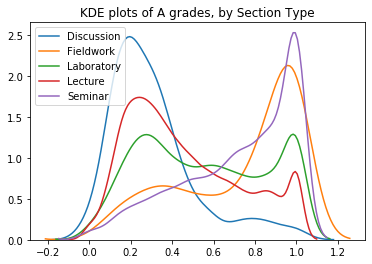

In [90]:
# Graphs of a_perc and ab_perc as a function of section_type

# Histograms for each section type
sns.kdeplot(data=uw_section_grades_training.loc[uw_section_grades_training['section_type'] == 'DIS']['a_perc'],
             label="Discussion", shade=False)

sns.kdeplot(data=uw_section_grades_training.loc[uw_section_grades_training['section_type'] == 'FLD']['a_perc'],
             label="Fieldwork", shade=False)

sns.kdeplot(data=uw_section_grades_training.loc[uw_section_grades_training['section_type'] == 'LAB']['a_perc'],
             label="Laboratory", shade=False)

sns.kdeplot(data=uw_section_grades_training.loc[uw_section_grades_training['section_type'] == 'LEC']['a_perc'],
             label="Lecture", shade=False)

sns.kdeplot(data=uw_section_grades_training.loc[uw_section_grades_training['section_type'] == 'SEM']['a_perc'],
             label="Seminar", shade=False)


# Add title
plt.title("KDE plots of A grades, by Section Type")

# Force legend to appear
plt.legend()
plt.show()
plt.close()


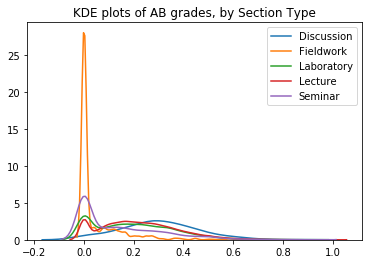

In [91]:
# Graphs of a_perc and ab_perc as a function of section_type

# Histograms for each section type
sns.kdeplot(data=uw_section_grades_training.loc[uw_section_grades_training['section_type'] == 'DIS']['ab_perc'],
             label="Discussion", shade=False)

sns.kdeplot(data=uw_section_grades_training.loc[uw_section_grades_training['section_type'] == 'FLD']['ab_perc'],
             label="Fieldwork", shade=False)

sns.kdeplot(data=uw_section_grades_training.loc[uw_section_grades_training['section_type'] == 'LAB']['ab_perc'],
             label="Laboratory", shade=False)

sns.kdeplot(data=uw_section_grades_training.loc[uw_section_grades_training['section_type'] == 'LEC']['ab_perc'],
             label="Lecture", shade=False)

sns.kdeplot(data=uw_section_grades_training.loc[uw_section_grades_training['section_type'] == 'SEM']['ab_perc'],
             label="Seminar", shade=False)


# Add title
plt.title("KDE plots of AB grades, by Section Type")

# Force legend to appear
plt.legend()
plt.show()
plt.close()



We see here that the 
## The what?

All of the other variables that I have are, I think, either Boolean or quantitative at this point (though ```subject_code``` should probably not be treated as one). I'm going to use scatterplots for most of these, perhaps colored by ```section_type``` and see what I find. In order to try to reduce the business of the plots, I'm going to randomly select a subset of 100 rows from each of the classes in the ```color_by``` column, using the following function.

In [92]:
def subset_dataframe(df, col, k = 100):
    
    new_df = pd.DataFrame()
    
    col_values = list(set(df[col].values.tolist()))
    
    for value in col_values:
        try:
            df1 = df.loc[df[col] == value].sample(n = k)
        except:
            df1 = df.loc[df[col] == value]
        new_df = pd.concat([new_df, df1], axis = 0)
    
    return new_df

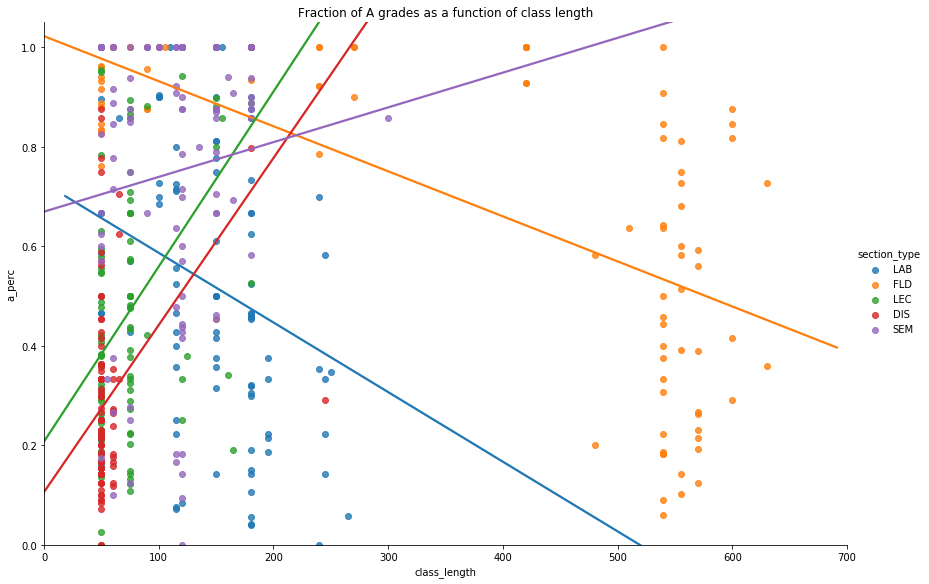

In [93]:
# Class length

sns.lmplot(x='class_length', 
           y='a_perc', 
           hue='section_type',
           data = subset_dataframe(uw_section_grades_training, 'section_type'), height = 8, aspect = 1.5, ci = None)
plt.xlim(0, 700)
plt.ylim(0, 1.05)
plt.title('Fraction of A grades as a function of class length')

plt.show()
plt.close()

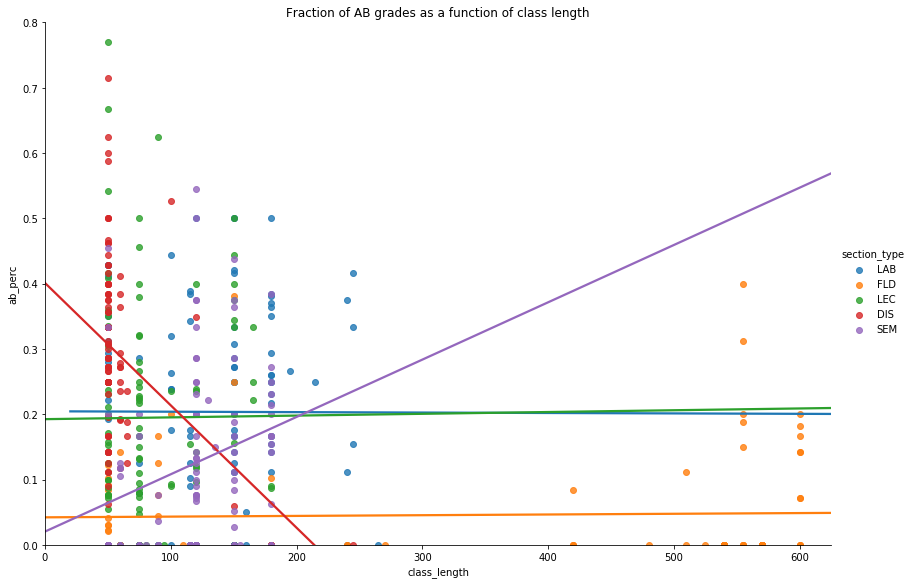

In [94]:
# Class length

sns.lmplot(x='class_length', 
           y='ab_perc', 
           hue='section_type',
           data = subset_dataframe(uw_section_grades_training, 'section_type'), height = 8, aspect = 1.5, ci = None)
plt.xlim(0, 625)
plt.ylim(0, 0.80)
plt.title('Fraction of AB grades as a function of class length')

plt.show()
plt.close()

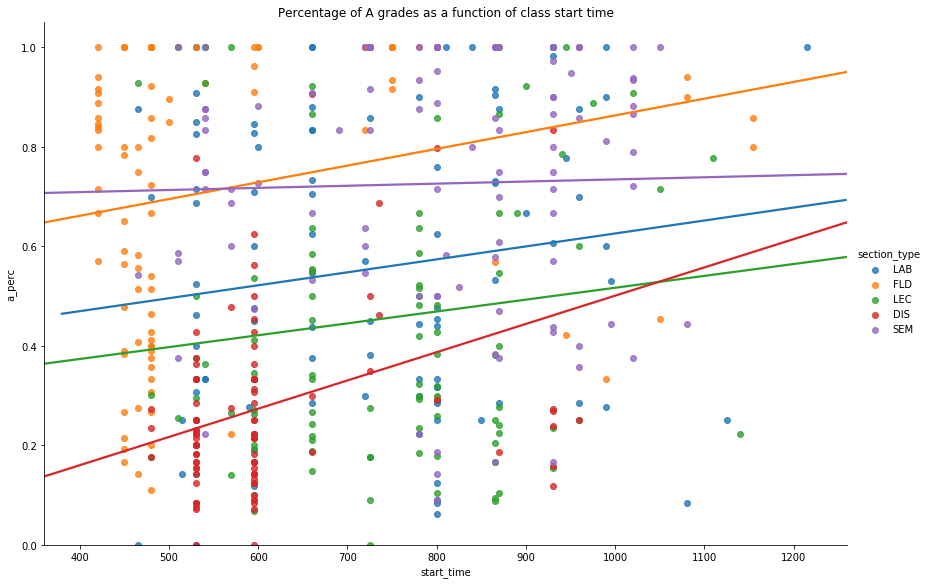

In [95]:
# start time

sns.lmplot(x='start_time', 
           y='a_perc', 
           hue='section_type',
           data = subset_dataframe(uw_section_grades_training, 'section_type'), height = 8, aspect = 1.5, ci = None)
plt.xlim(360, 1260)
plt.ylim(0, 1.05)
plt.title('Percentage of A grades as a function of class start time')

plt.show()
plt.close()

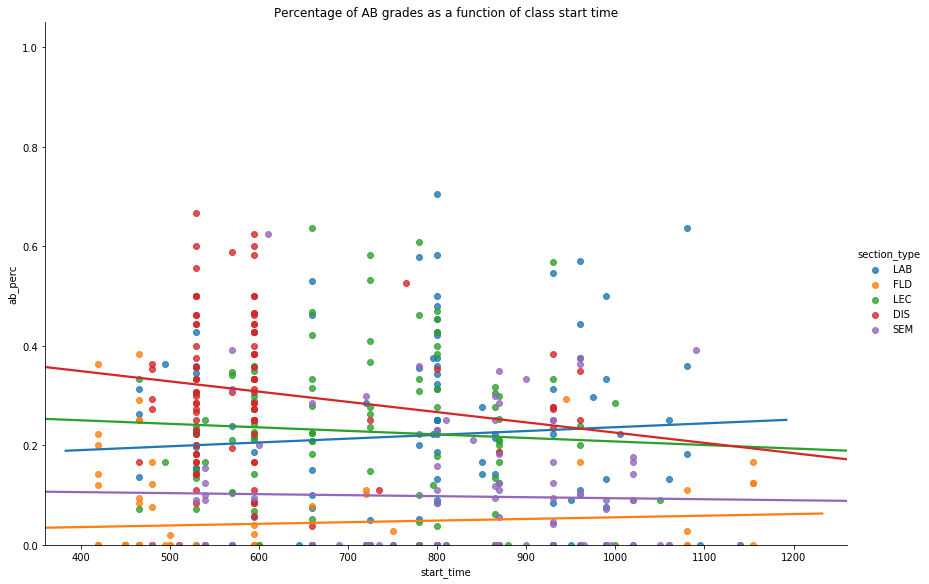

In [96]:
# start time

sns.lmplot(x='start_time', 
           y='ab_perc', 
           hue='section_type',
           data = subset_dataframe(uw_section_grades_training, 'section_type'), height = 8, aspect = 1.5, ci = None)
plt.xlim(360, 1260)
plt.ylim(0, 1.05)
plt.title('Percentage of AB grades as a function of class start time')

plt.show()
plt.close()

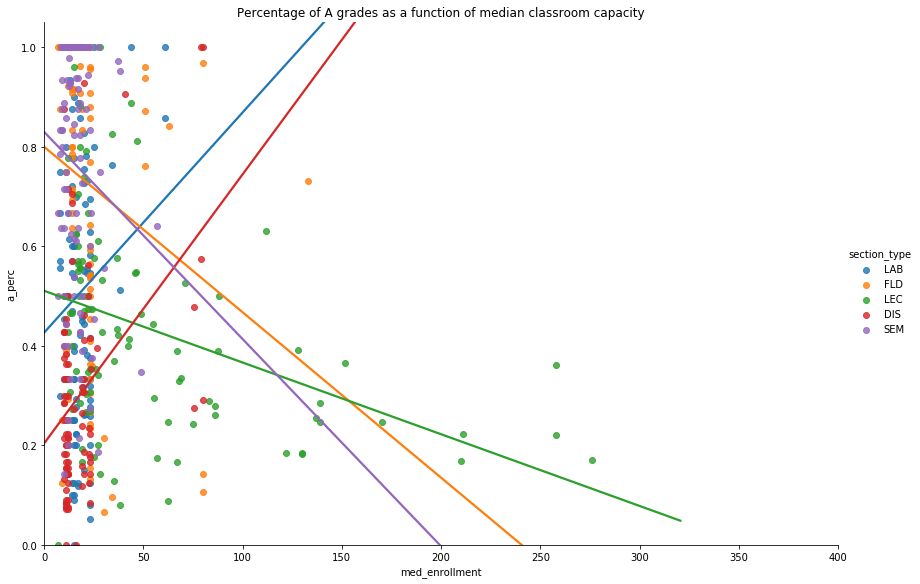

In [97]:
# median classroom capacity

sns.lmplot(x='med_enrollment', 
           y='a_perc', 
           hue='section_type',
           data = subset_dataframe(uw_section_grades_training, 'section_type'), height = 8, aspect = 1.5, ci = None)
plt.xlim(0, 400)
plt.ylim(0, 1.05)
plt.title('Percentage of A grades as a function of median classroom capacity')

plt.show()
plt.close()

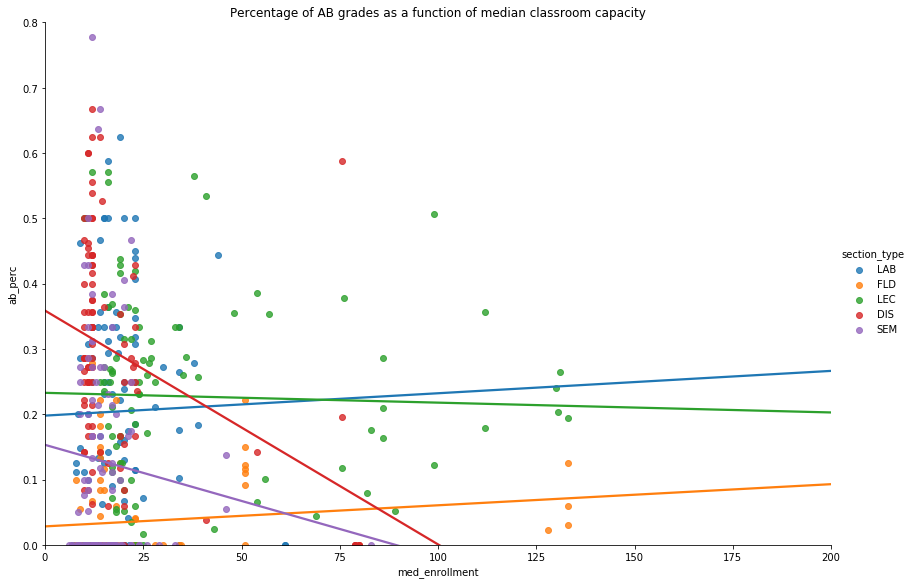

In [98]:
# median classroom capacity

sns.lmplot(x='med_enrollment', 
           y='ab_perc', 
           hue='section_type',
           data = subset_dataframe(uw_section_grades_training, 'section_type'), height = 8, aspect = 1.5, ci = None)
plt.xlim(0, 200)
plt.ylim(0, 0.8)
plt.title('Percentage of AB grades as a function of median classroom capacity')

plt.show()
plt.close()

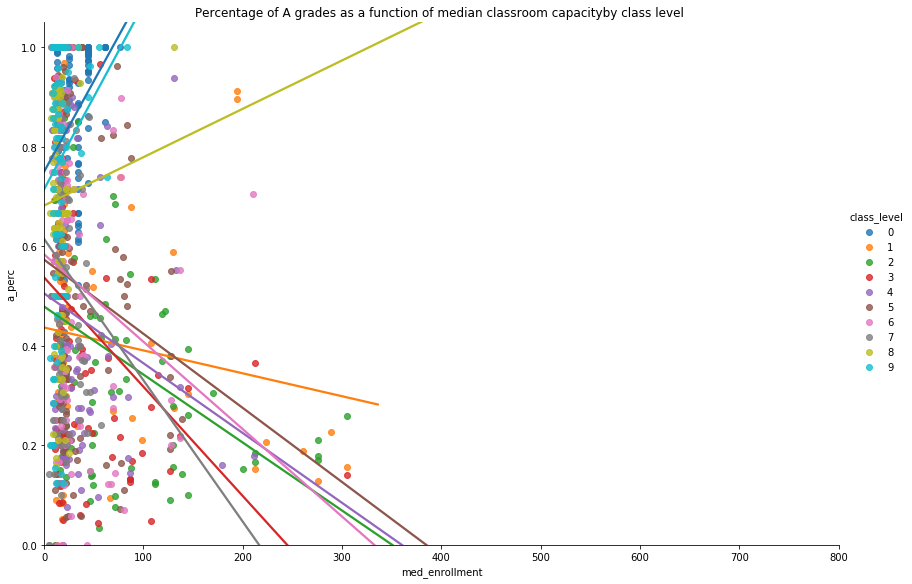

In [99]:
# maximal classroom capacity

sns.lmplot(x='med_enrollment', 
           y='a_perc', 
           hue='class_level',
           data = subset_dataframe(uw_section_grades_training, 'class_level'), height = 8, aspect = 1.5, ci = None)
plt.xlim(0, 800)
plt.ylim(0, 1.05)
plt.title('Percentage of A grades as a function of median classroom capacityby class level ')

plt.show()
plt.close()

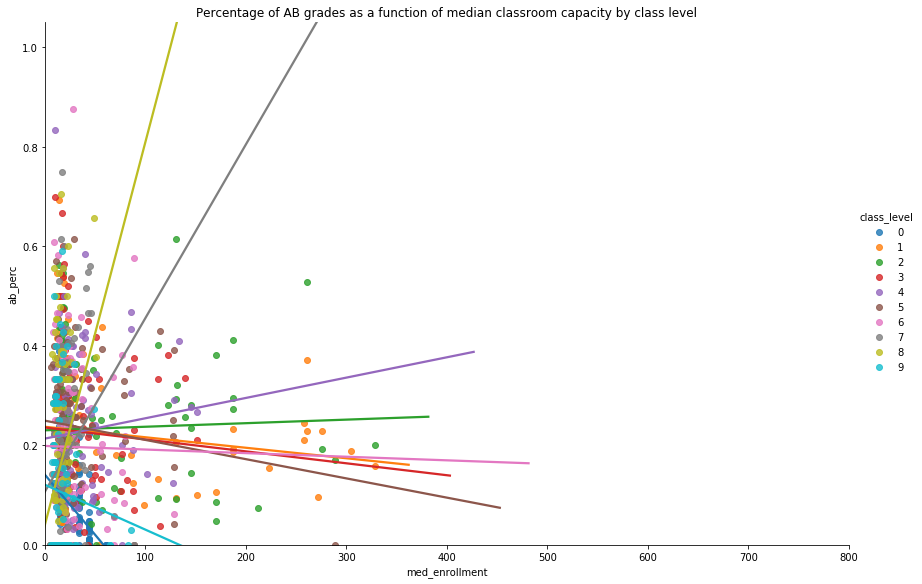

In [100]:
# maximal classroom capacity

sns.lmplot(x='med_enrollment', 
           y='ab_perc', 
           hue='class_level',
           data = subset_dataframe(uw_section_grades_training, 'class_level'), height = 8, aspect = 1.5, ci = None)
plt.xlim(0, 800)
plt.ylim(0, 1.05)
plt.title('Percentage of AB grades as a function of median classroom capacity by class level')

plt.show()
plt.close()

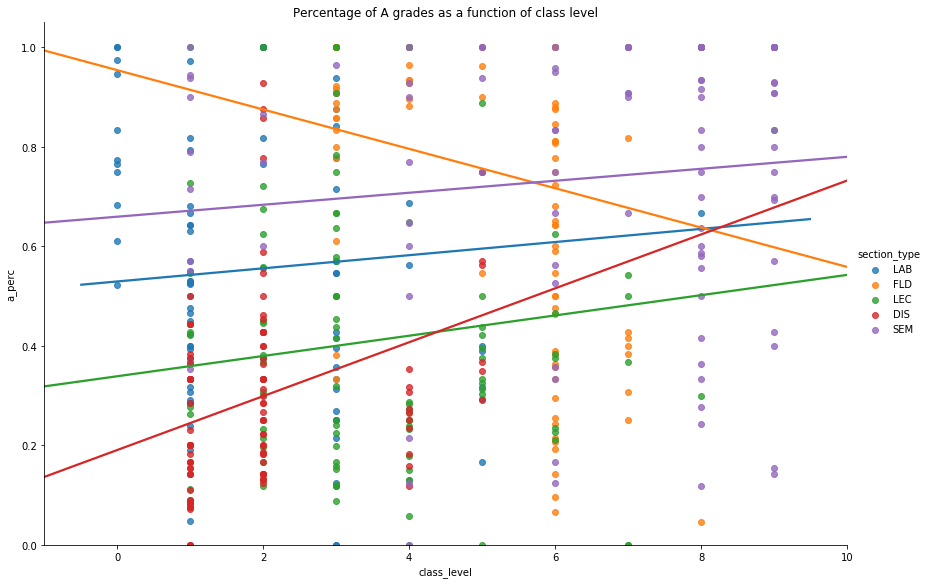

In [101]:
# class_level

sns.lmplot(x='class_level', 
           y='a_perc', 
           hue='section_type',
           data = subset_dataframe(uw_section_grades_training, 'section_type'), height = 8, aspect = 1.5, ci = None)
plt.xlim(-1, 10)
plt.ylim(0, 1.05)
plt.title('Percentage of A grades as a function of class level')

plt.show()
plt.close()

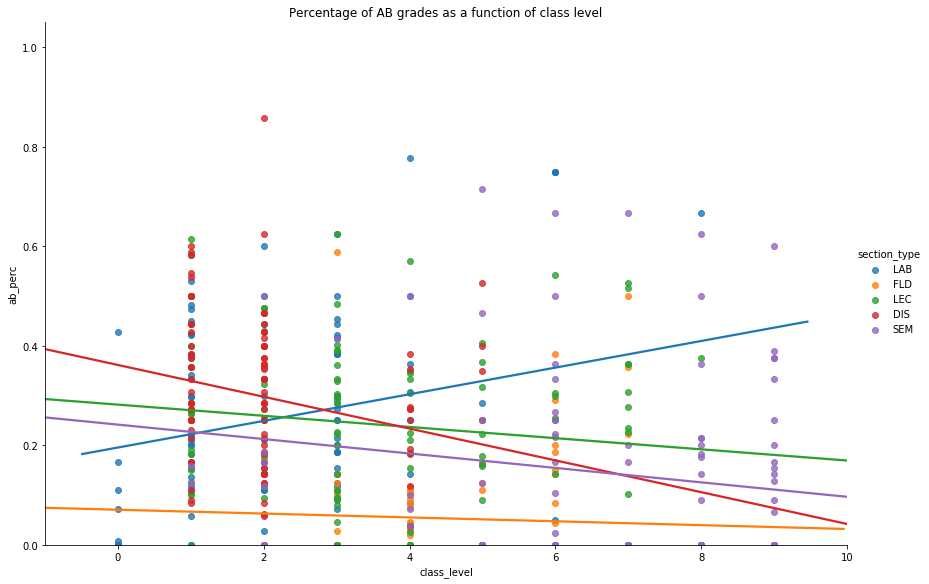

In [102]:
# class_level

sns.lmplot(x='class_level', 
           y='ab_perc', 
           hue='section_type',
           data = subset_dataframe(uw_section_grades_training, 'section_type'), height = 8, aspect = 1.5, ci = None)
plt.xlim(-1, 10)
plt.ylim(0, 1.05)
plt.title('Percentage of AB grades as a function of class level')

plt.show()
plt.close()

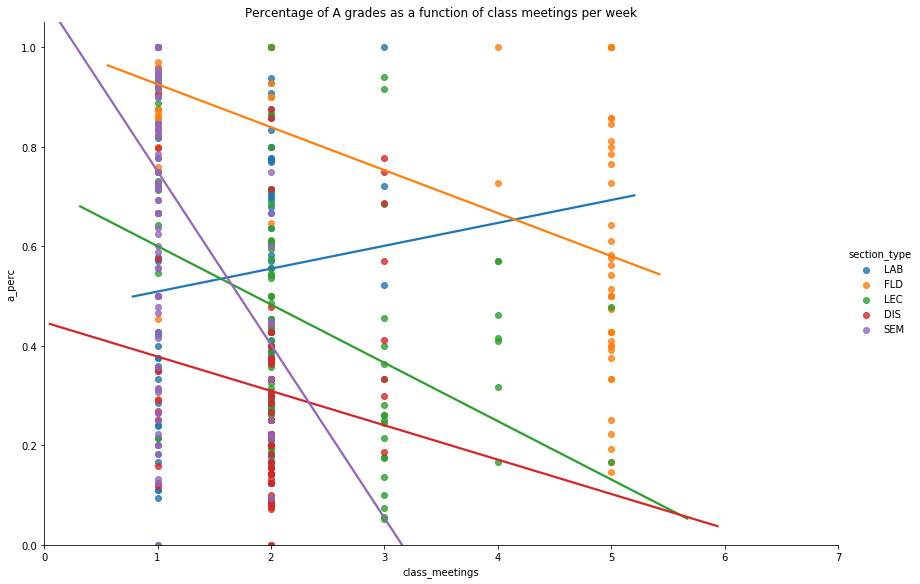

In [103]:
# class_meetings, number_sections, term_code, subject_code

sns.lmplot(x='class_meetings', 
           y='a_perc', 
           hue='section_type',
           data = subset_dataframe(uw_section_grades_training, 'section_type'), height = 8, aspect = 1.5, ci = None)
plt.xlim(0, 7)
plt.ylim(0, 1.05)
plt.title('Percentage of A grades as a function of class meetings per week')

plt.show()
plt.close()

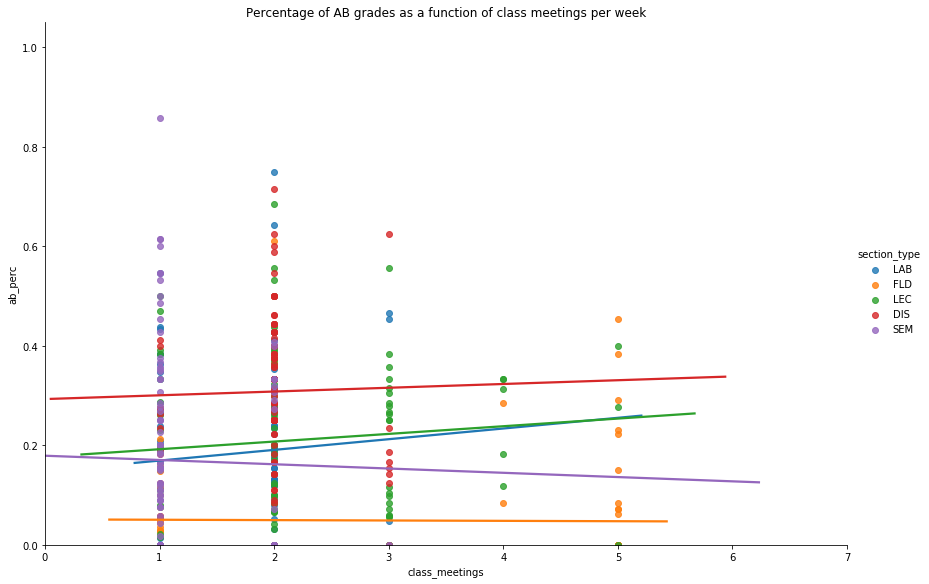

In [104]:
# class_meetings, number_sections, term_code, subject_code

sns.lmplot(x='class_meetings', 
           y='ab_perc', 
           hue='section_type',
           data = subset_dataframe(uw_section_grades_training, 'section_type'), height = 8, aspect = 1.5, ci = None)
plt.xlim(0, 7)
plt.ylim(0, 1.05)
plt.title('Percentage of AB grades as a function of class meetings per week')

plt.show()
plt.close()

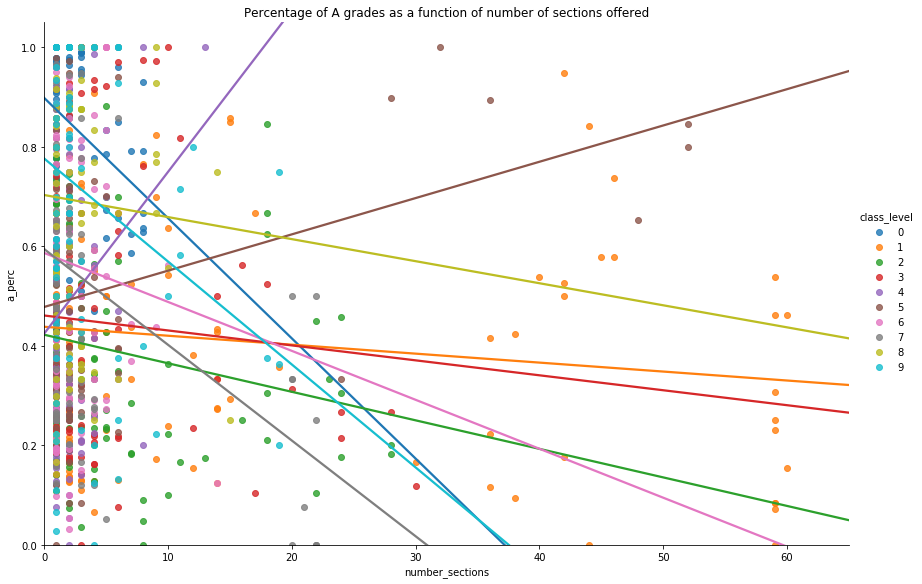

In [105]:
#  number_sections, term_code, subject_code

sns.lmplot(x='number_sections', 
           y='a_perc', 
           hue='class_level',
           data = subset_dataframe(uw_section_grades_training, 'class_level'), height = 8, aspect = 1.5, ci = None)
plt.xlim(0, 65)
plt.ylim(0, 1.05)
plt.title('Percentage of A grades as a function of number of sections offered')

plt.show()
plt.close()

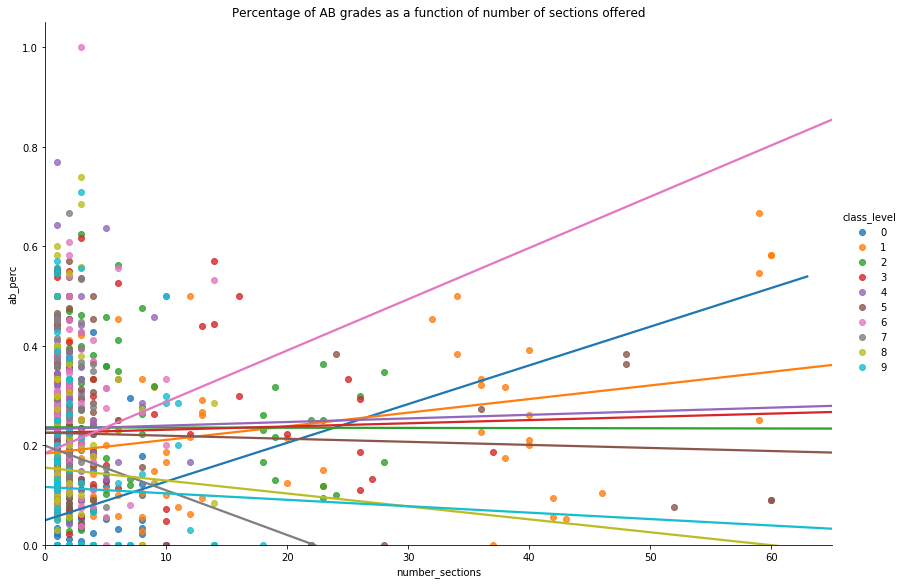

In [106]:
#  number_sections, term_code, subject_code

sns.lmplot(x='number_sections', 
           y='ab_perc', 
           hue = 'class_level', 
           data = subset_dataframe(uw_section_grades_training, 'class_level'), height = 8, aspect = 1.5, ci = None)
plt.xlim(0, 65)
plt.ylim(0, 1.05)
plt.title('Percentage of AB grades as a function of number of sections offered')

plt.show()
plt.close()

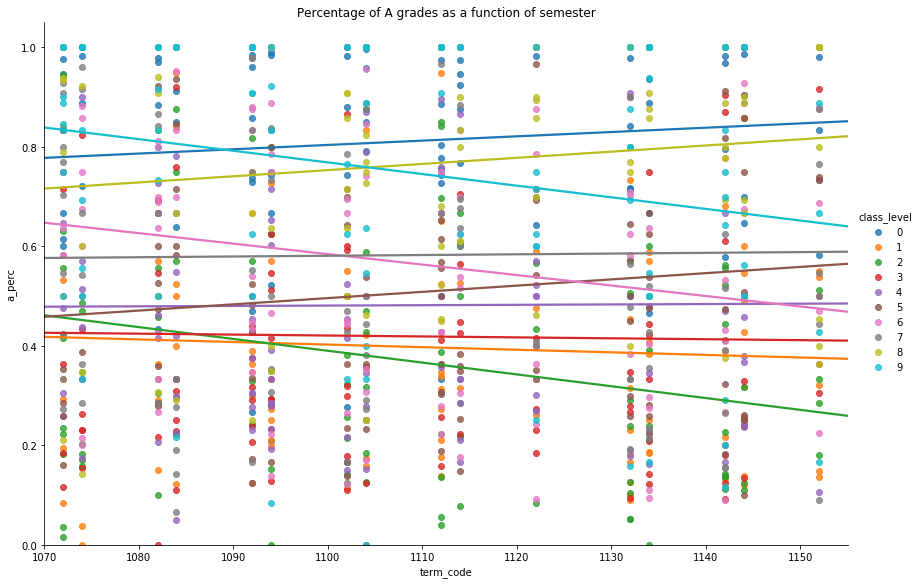

In [107]:
#  term_code, subject_code

sns.lmplot(x='term_code', 
           y='a_perc', 
           hue = 'class_level', 
           data = subset_dataframe(uw_section_grades_training, 'class_level'), height = 8, aspect = 1.5, ci = None)
plt.xlim(1070, 1155)
plt.ylim(0, 1.05)
plt.title('Percentage of A grades as a function of semester')

plt.show()
plt.close()

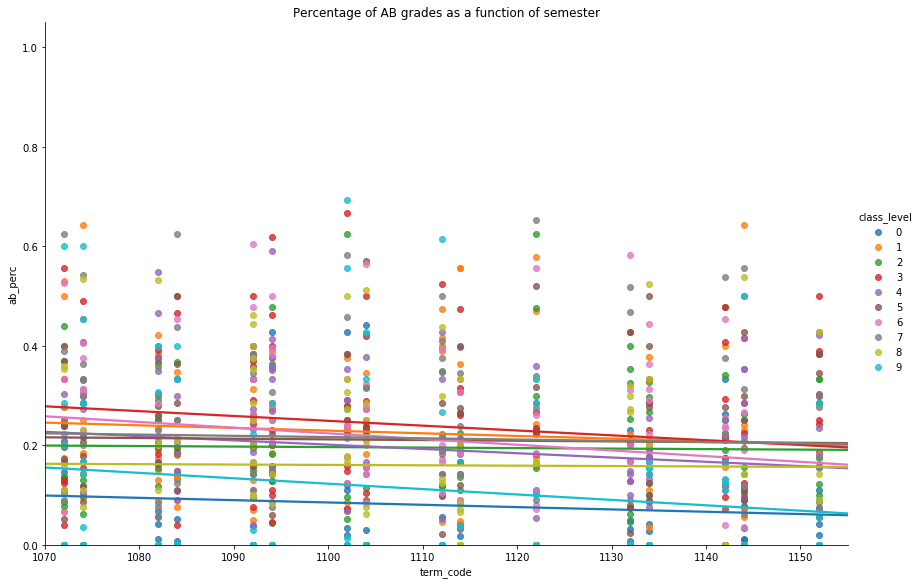

In [108]:
#  term_code, subject_code

sns.lmplot(x='term_code', 
           y='ab_perc', 
           hue = 'class_level', 
           data = subset_dataframe(uw_section_grades_training, 'class_level'), height = 8, aspect = 1.5, ci = None)
plt.xlim(1070, 1155)
plt.ylim(0, 1.05)
plt.title('Percentage of AB grades as a function of semester')

plt.show()
plt.close()

Is there any rhyme or reason to the subject code assignments? If so, these may be usable. Otherwise, I think that they're probably worthless, even __IF__ I'm quite sure that the subject has an impact on grade distributions.

In [109]:
subjects = subjects.sort_values('code')

subjects.reset_index(inplace = True, drop = True)

In [110]:
subjects.drop([198, 199], axis = 0, inplace = True)

In [111]:
pd.options.display.max_rows = 200
subjects

,code,name,abbreviation
0,102,Air Force Aerospace Studies,A F AERO
1,104,African Languages and Literature,AFRICAN
2,106,Afro-American Studies,AFROAMER
3,108,Agricultural and Applied Economics,A A E
4,112,Biological Systems Engineering,BSE
5,120,Life Sciences Communication,LSC
6,130,Agroecology,AGROECOL
7,132,Agronomy,AGRONOMY
8,140,American Indian Studies,AMER IND
9,144,Anatomy,ANATOMY


Looking at these, the biggest determiner of subject code seems to be alphabetical order, which means that mathematics and statistics (for example) are far apart, but Spanish and statistics are adjacent to each other. So, as things currently stand, I'm likely going to need to either drop this or do some language processing on it, which I'm not sure that I want to do. For now then, I think that I'm ready to further reduce my dataframe and to see how good of a model I can get.

In [112]:
uw_section_grades.columns.tolist()

['a_perc',
 'ab_perc',
 'b_perc',
 'bc_perc',
 'c_perc',
 'd_perc',
 'f_perc',
 'section_type',
 'start_time',
 'end_time',
 'mon',
 'tues',
 'wed',
 'thurs',
 'fri',
 'sat',
 'sun',
 'class_length',
 'term_code',
 'class_level',
 'subject_code',
 'class_meetings',
 'max_enrollment',
 'min_enrollment',
 'med_enrollment',
 'third_quart',
 'number_sections',
 'section_number']

In [113]:
to_drop = ['end_time', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun',
           'subject_code','max_enrollment', 'min_enrollment','third_quart', 'section_number']

uw_section_grades.drop(to_drop, axis = 1, inplace = True)

In [114]:
# And repeating the split without these columns

uw_section_grades_training = uw_section_grades.loc[uw_section_grades['term_code'] < 1153].copy()

uw_section_grades_training.reset_index(drop = True, inplace = True)

uw_section_grades_validation = uw_section_grades.loc[(uw_section_grades['term_code'] < 1165) & 
                                                     (uw_section_grades['term_code'] > 1153)].copy()

uw_section_grades_validation.reset_index(drop = True, inplace = True)

uw_section_grades_testing = uw_section_grades.loc[uw_section_grades['term_code'] > 1165].copy()

uw_section_grades_testing.reset_index(drop = True, inplace = True)

In [115]:
uw_section_grades_training.head()

,a_perc,ab_perc,b_perc,bc_perc,c_perc,d_perc,f_perc,section_type,start_time,class_length,term_code,class_level,class_meetings,med_enrollment,number_sections
0,0.926829,0.048780,0.000000,0.000000,0.0,0.0,0.000000,LAB,800.0,50.0,1074,0,2.0,34.0,1.0
1,0.583333,0.083333,0.166667,0.166667,0.0,0.0,0.000000,LAB,595.0,50.0,1152,0,2.0,21.0,8.0
2,0.791667,0.041667,0.000000,0.041667,0.0,0.0,0.083333,LAB,660.0,100.0,1152,0,1.0,14.0,8.0
3,0.700000,0.100000,0.100000,0.000000,0.0,0.0,0.100000,LAB,660.0,100.0,1152,0,1.0,14.0,8.0
4,0.666667,0.083333,0.208333,0.000000,0.0,0.0,0.000000,LAB,800.0,50.0,1152,0,2.0,15.0,8.0


### Step 5

I need to fit a baseline model to what I have here, but in order to do that I want to scale my quantitative variables and encode my categorical variables. From the point of view of my models, the grade percent columns are all response variables, so I'm not actually going to touch them.

I need to split my data into feature and response variables.

Also, I want to build a pipeline here (my first one!) in order to ensure that all of my data ends up getting the same treatment.

In [116]:
uw_section_grades_training.columns.tolist()

['a_perc',
 'ab_perc',
 'b_perc',
 'bc_perc',
 'c_perc',
 'd_perc',
 'f_perc',
 'section_type',
 'start_time',
 'class_length',
 'term_code',
 'class_level',
 'class_meetings',
 'med_enrollment',
 'number_sections']

In [117]:
y_train = uw_section_grades_training.loc[:, ['a_perc', 'ab_perc', 'b_perc', 'bc_perc', 
                                             'c_perc', 'd_perc', 'f_perc']]

y_val = uw_section_grades_validation.loc[:, ['a_perc', 'ab_perc', 'b_perc', 'bc_perc', 
                                             'c_perc', 'd_perc', 'f_perc']]

y_test = uw_section_grades_testing.loc[:, ['a_perc', 'ab_perc', 'b_perc', 'bc_perc', 
                                             'c_perc', 'd_perc', 'f_perc']]

X_train = uw_section_grades_training.loc[:, ['section_type', 'start_time', 'class_length', 
                                             'term_code', 'class_level', 'class_meetings', 
                                             'med_enrollment', 'number_sections']]

X_val = uw_section_grades_validation.loc[:, ['section_type', 'start_time', 'class_length', 
                                             'term_code', 'class_level', 'class_meetings', 
                                             'med_enrollment', 'number_sections']]

X_test = uw_section_grades_testing.loc[:, ['section_type', 'start_time', 'class_length', 
                                             'term_code', 'class_level', 'class_meetings', 
                                             'med_enrollment', 'number_sections']]

In [118]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [119]:
numerical_cols = ['start_time', 'class_length', 'term_code', 'class_level', 
                  'class_meetings', 'med_enrollment', 'number_sections']
categorical_cols = ['section_type']

In [120]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

base_preprocessor = ColumnTransformer(transformers = [
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

In [121]:
from sklearn.linear_model import LinearRegression

base_model = LinearRegression()

In [122]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
base_pipeline = Pipeline(steps=[('preprocessor', base_preprocessor),
                              ('model', base_model)
                             ])

# Preprocessing of training data, fit model 
base_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = base_pipeline.predict(X_val)

# Evaluate the model
score = mean_absolute_error(y_val, preds)
print('MAE:', score)

MAE: 0.08024671376080339


WooHoo! I made my first pipeline. It is the simplest of models, and has an MAE of 0.0803. Now, I can go ahead and try out some other models! 

## Step 5: More modeling

Next up, I want to look at some other models, which I'm going to go ahead and list here in order to keep track of them. 

First, I can use either
1. MultiOutputRegressor (which doesn't take dependencies between the response variables into account), or
2. RegressorChain (which does take those dependencies into account)
nested with any of my regression models in order to fit to all of the responses simultaneously. Both of these can be found in the MultiOutput sublibrary of sklearn.

Secondly, I want to consider the following models
1. KNN regressor
2. RandomForest
3. AdaBoost
4. Support Vector Machines
5. Lasso
6. Elastic Net

And finally, the MLPRegressor which is a fairly basic neural network model. 

Obviously, most of these will need to be tuned, and I think that I'm going to fit to my training set and then use performance on the validation set to choose the best values for my tuneable parameters.

## KNN regressor

In [123]:
from sklearn.neighbors import KNeighborsRegressor

In [124]:
def knn_tune(X, y, X_valid, y_valid, k = 3):
    
    knn_model = KNeighborsRegressor(k)
    
    knn_pipeline = Pipeline(steps=[('preprocessor', base_preprocessor),
                              ('model', knn_model)
                             ])
    
    knn_pipeline.fit(X, y)
    preds = knn_pipeline.predict(X_valid)
    score = mean_absolute_error(y_valid, preds)
    
    return score

In [125]:
scores = []
for n in range(1,20):
    mae = knn_tune(X_train, y_train, X_val, y_val, n)
    scores.append(mae)
    
best_value = np.argmin(scores)

print('The best value for n is', best_value)

The best value for n is 16


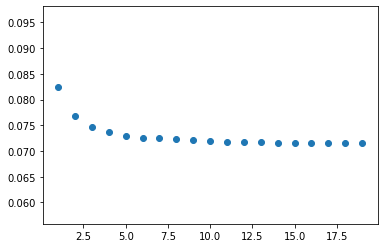

In [126]:
plt.scatter(range(1, 20), scores)
plt.show()
plt.close()

Looking at the graph, it appears that, though the best value, in some sense, may be 16, the amount of improvement we get past about k = 6 or 7 is fairly minimal. For this reason, I'm also going to fit a model using k = 7.

### KNN regression model

Combining the training and validation sets into a single dataframe, I can then use this to create a KNN_pipeline.

In [127]:
X_big_train = pd.concat([X_train, X_val])
y_big_train = pd.concat([y_train, y_val])

In [128]:
knn_model_7 = KNeighborsRegressor(7)
    
KNN_pipeline_7 = Pipeline(steps=[('preprocessor', base_preprocessor),
                              ('model', knn_model_7)
                             ])
    
KNN_pipeline_7.fit(X_big_train, y_big_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['start_time', 'class_length',
                                                   'term_code', 'class_level',
                                                   'class_meetings',
                                                   'med_enrollment',
                                                   'number_sections']),
                                                 ('cat',
                                       

In [129]:
knn_model_best = KNeighborsRegressor(best_value)
    
KNN_pipeline_best = Pipeline(steps=[('preprocessor', base_preprocessor),
                              ('model', knn_model_best)
                             ])
    
KNN_pipeline_best.fit(X_big_train, y_big_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['start_time', 'class_length',
                                                   'term_code', 'class_level',
                                                   'class_meetings',
                                                   'med_enrollment',
                                                   'number_sections']),
                                                 ('cat',
                                       

## Random Forest Regressor

To begin with, what is my parameter search space? 
- number of estimators
- criterion
- max depth
- max features

There are other things that I could vary, but I think that this will already give me plenty of stuff to work with.

In [130]:
from sklearn.ensemble import RandomForestRegressor

In [131]:
num_est = [10, 25, 50, 100]
depth = [1, 2, 3, 5, 7, 10]
feat = ["auto", "sqrt", "log2"]

RFR_params = []

for a in num_est:
    for c in depth:
        for d in feat:
                RFR_params.append([a, c, d])
                
len(RFR_params)

72

In [132]:
def rfr_tune(X, y, X_valid, y_valid, param_vect):
    
    rfr_model = RandomForestRegressor(n_estimators=param_vect[0], 
                                      max_depth=param_vect[1], 
                                      max_features=param_vect[2])
    
    rfr_pipeline = Pipeline(steps=[('preprocessor', base_preprocessor),
                              ('model', rfr_model)
                             ])
    
    rfr_pipeline.fit(X, y)
    preds = rfr_pipeline.predict(X_valid)
    score = mean_absolute_error(y_valid, preds)
    
    return score    

In [133]:
scores = []

for i in range(len(RFR_params)):

    score = rfr_tune(X_train, y_train, X_val, y_val, RFR_params[i])
    scores.append(score)
    #print('Parameters are', RFR_params[i])
    
best_combo = np.argmin(scores)
    
print('The best values are: ')   
print('     n_estimators', RFR_params[best_combo][0])
print('     max_depth', RFR_params[best_combo][1])
print('     max_features', RFR_params[best_combo][2])

The best values are: 
     n_estimators 25
     max_depth 10
     max_features auto


In [134]:
RFR_params[best_combo]

[25, 10, 'auto']

#### Random Forest Regressor Model

In [135]:
rfr_model = RandomForestRegressor(n_estimators = RFR_params[best_combo][0], 
                                  max_depth = RFR_params[best_combo][1], 
                                  max_features = RFR_params[best_combo][2])
    
RFR_pipeline = Pipeline(steps=[('preprocessor', base_preprocessor),
                              ('model', rfr_model)
                             ])
    
RFR_pipeline.fit(X_big_train, y_big_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['start_time', 'class_length',
                                                   'term_code', 'class_level',
                                                   'class_meetings',
                                                   'med_enrollment',
                                                   'number_sections']),
                                                 ('cat',
                                       

## AdaBoost Regressor

Once again, I need a parameter search space in order to find the best model to train

- number of estimators
- learning rate
- loss function

I could try to specify a base estimator, but I'm not entirely sure that I'd end up getting much extra benefit from that. 

OK, and here I'm going to have to wrap things in a MultiOutputRegressor or RegressorChain call.

In [136]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

In [137]:
n_est = [10, 25, 50, 100]
l_rate = [0.1, 0.25, 0.5, 1.0]
loss_func = ['linear', 'square', 'exponential']

AB_params = []
for a in n_est:
    for b in l_rate:
        for c in loss_func:
            AB_params.append([a, b, c])
            
len(AB_params)

48

In [138]:
def AB_tune(X, y, X_valid, y_valid, param_vect):
    
    ab_model = MultiOutputRegressor(AdaBoostRegressor(n_estimators=param_vect[0], 
                                                      learning_rate=param_vect[1], 
                                                      loss=param_vect[2]))
    
    ab_pipeline = Pipeline(steps = [('preprocessor', base_preprocessor), ('model', ab_model)])
    
    ab_pipeline.fit(X, y)
    
    preds = ab_pipeline.predict(X_valid)
    
    score = mean_absolute_error(y_valid, preds)
    
    return score

In [139]:
# Checking the function implementation

AB_tune(X_train, y_train, X_val, y_val, AB_params[0])

0.0785208835811618

In [140]:
scores = []
for i in range(len(AB_params)):
    
    score = AB_tune(X_train, y_train, X_val, y_val, AB_params[i])
    
    scores.append(score)
    #print('Parameters are', AB_params[i])
    
best_combo = np.argmin(scores)
    
print('The best values are: ')   
print('     n_estimators', AB_params[best_combo][0])
print('     learning_rate', AB_params[best_combo][1])
print('     loss function', AB_params[best_combo][2])
print('The mae for this model is', scores[best_combo])

The best values are: 
     n_estimators 10
     learning_rate 0.1
     loss function exponential
The mae for this model is 0.0784289582381361


### AdaBoost Regressor Model

In [141]:
ab_model = MultiOutputRegressor(AdaBoostRegressor(n_estimators = AB_params[best_combo][0], 
                                                  learning_rate = AB_params[best_combo][1], 
                                                  loss = AB_params[best_combo][2]))
    
AB_pipeline = Pipeline(steps=[('preprocessor', base_preprocessor),
                              ('model', ab_model)
                             ])
    
AB_pipeline.fit(X_big_train, y_big_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['start_time', 'class_length',
                                                   'term_code', 'class_level',
                                                   'class_meetings',
                                                   'med_enrollment',
                                                   'number_sections']),
                                                 ('cat',
                                       

## Support Vector Machines

Here I'm fairly sure that I can't actually do this without wrapping my model in MultiOutputRegressor. Also, I need to look at what sorts of things I need to tune over. I think that I'm going to have to go with a linear kernel, at least for starters, due to the size of my dataset (the suggestion on the sci-kit learn page is that the SVR model doesn't work well for more than about 10000 datapoints, and I have roughly an order of magnitude more than that. That means that I don't need/get to choose a kernel, but I can choose C as well as the loss function that I'm using. I'll leave everything else with default values for the time being.
- C (the regularization parameter)
- loss (the penalty)

In [142]:
from sklearn.svm import LinearSVR

In [143]:
reg = [0.0001, 0.001, 0.01, 0.1]
losses = ['epsilon_insensitive', 'squared_epsilon_insensitive']

SVM_params = []
for a in reg:
    for b in losses:
        SVM_params.append([a,b])
        
print('You have ', len(SVM_params), 'combinations to check')

You have  8 combinations to check


In [144]:
def tune_SVR(X, y, X_valid, y_valid, param_vect):
    
    svr_model = MultiOutputRegressor(LinearSVR(C = param_vect[0], loss = param_vect[1], max_iter = 5000))
    
    svr_pipeline = Pipeline(steps = [('preprocessor', base_preprocessor), ('model', svr_model)])
    svr_pipeline.fit(X, y)
    
    preds = svr_pipeline.predict(X_valid)
    
    score = mean_absolute_error(preds, y_valid)
    
    return score

In [145]:
# Checking that the tuning function is well defined

tune_SVR(X_train, y_train, X_val, y_val, SVM_params[0])

0.07681569907507413

In [146]:
scores = []
for i in range(len(SVM_params)):
    score = tune_SVR(X_train, y_train, X_val, y_val, SVM_params[i])
    scores.append(score)
    #print('The current parameters are', SVM_params[i])
    
best_combo = np.argmin(scores)
    
print('The best values are:')
print('        regularization ', SVM_params[best_combo][0])
print('        loss function', SVM_params[best_combo][1])
print('The mae for this model is', scores[best_combo])

/Users/rebekaharana/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rebekaharana/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rebekaharana/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The best values are:
        regularization  0.1
        loss function epsilon_insensitive
The mae for this model is 0.07621061283106731


### Support Vector Regressor Model

In [147]:
svr_model = MultiOutputRegressor(LinearSVR(C = SVM_params[best_combo][0], 
                                           loss = SVM_params[best_combo][1],
                                           max_iter = 10000))
    
SVR_pipeline = Pipeline(steps = [('preprocessor', base_preprocessor), 
                                 ('model', svr_model)])

SVR_pipeline.fit(X_big_train, y_big_train)

/Users/rebekaharana/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/rebekaharana/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['start_time', 'class_length',
                                                   'term_code', 'class_level',
                                                   'class_meetings',
                                                   'med_enrollment',
                                                   'number_sections']),
                                                 ('cat',
                                       

## ElasticNet Model

This combines L1 (Lasso) and L2 (Ridge Regression) penalties according to the value of ll_ratio. Here I think that I want to tune
- alpha (the learning rate)
- ll_ratio (the balance between L1 and L2 penalties)

I'll leave the other parameters set to their defaults.

In [148]:
from sklearn.linear_model import ElasticNet

In [149]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
ll_ratios = [0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

EN_params = []
for a in alphas:
    for b in ll_ratios:
        EN_params.append([a, b])
        
print('You have', len(EN_params), 'parameter combinations to consider')

You have 48 parameter combinations to consider


In [150]:
def EN_tune(X, y, X_valid, y_valid, param_vect):
    
    en_model = MultiOutputRegressor(ElasticNet(alpha = param_vect[0], 
                                               l1_ratio = param_vect[1],
                                               selection='cyclic',
                                               max_iter = 5000))
    
    en_pipeline = Pipeline(steps = [('preprocessor', base_preprocessor), ('model', en_model)])
    
    en_pipeline.fit(X,y)
    preds = en_pipeline.predict(X_valid)
    score = mean_absolute_error(preds, y_valid)
    
    return score

In [151]:
# Checking that the function EN_tune is well defined

EN_tune(X_train, y_train, X_val, y_val, EN_params[0])

0.08023114219534848

In [152]:
scores = []

for i in range(len(EN_params)):
    score = EN_tune(X_train, y_train, X_val, y_val, EN_params[i])
    scores.append(score)
    
    #print('The current parameters are', EN_params[i])
    
best_combo = np.argmin(scores)

print('The best parameters are:')
print('          alpha', EN_params[best_combo][0])
print('          ll_ratio', EN_params[best_combo][1])
print('The mae for this model is', scores[best_combo])

The best parameters are:
          alpha 0.001
          ll_ratio 0.02
The mae for this model is 0.08023109996381601


### ElasticNet Regressor Model

In [153]:
en_model = MultiOutputRegressor(ElasticNet(alpha = EN_params[best_combo][0], 
                                               l1_ratio = EN_params[best_combo][1],
                                               selection='cyclic'))
    
EN_pipeline = Pipeline(steps = [('preprocessor', base_preprocessor), ('model', en_model)])
    
EN_pipeline.fit(X_big_train, y_big_train)



Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['start_time', 'class_length',
                                                   'term_code', 'class_level',
                                                   'class_meetings',
                                                   'med_enrollment',
                                                   'number_sections']),
                                                 ('cat',
                                       

# Neural Networks

I'm going to try to use the sklearn multilayer perceptron model, and see how slow it ends up being. There are a lot of potential things to tune here, and I'm not entirely sure that I understand how all of them work, but I'm going to try to figure it out.
- hidden_layer_sizes (A tuple the length of which gives the number of hidden layers and the entries of which give the number of neurons in each successive hidden layer.)
- activation ('logistic', 'tanh', or 'relu')
- alpha (L2 regularization parameter)
- batch_size (the number of samples processed at each step)

For everything else, I'm just going to use the default values of the parameters.

In [154]:
from sklearn.neural_network import MLPRegressor

In [155]:
layers = [(64, ), (64, 64), (64, 32, 32)]
activations = ['relu']
alphas = [0.0001, 0.001, 0.01]

MLP_params = []
for a in layers:
    for b in activations:
            for d in alphas:
                MLP_params.append([a, b, d])
                
print('You have', len(MLP_params), 'parameter combinations to consider')

You have 9 parameter combinations to consider


In [156]:
def MLP_tune(X, y, X_valid, y_valid, param_vect):

    mlp_model = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=param_vect[0], 
                                                  activation=param_vect[1], 
                                                  alpha=param_vect[2], 
                                                  learning_rate_init=0.001, 
                                                  early_stopping=True, 
                                                  validation_fraction=0.1,
                                                  max_iter = 500))
    
    mlp_pipeline = Pipeline(steps = [('preprocessor', base_preprocessor), ('model', mlp_model)])

    mlp_pipeline.fit(X, y)
    preds = mlp_pipeline.predict(X_valid)
    score = mean_absolute_error(preds, y_valid)
    
    return score

In [157]:
MLP_tune(X_train, y_train, X_val, y_val, MLP_params[0])

#14h33

0.07338230164586186

In [158]:
scores = []
for i in range(len(MLP_params)):
    score = MLP_tune(X_train, y_train, X_val, y_val, MLP_params[i])
    scores.append(score)
    print('The current parameters are:', MLP_params[i])
    
best_combo = np.argmin(scores)
    
print('The best parameters are:')
print('     hidden_layer_sizes', MLP_params[best_combo][0])
print('     activation', MLP_params[best_combo][1])
print('     alpha', MLP_params[best_combo][2])
#print('     batch size', MLP_params[best_combo][2])
print('The mae for this model is', scores[best_combo])

The current parameters are: [(64,), 'relu', 0.0001]
The current parameters are: [(64,), 'relu', 0.001]
The current parameters are: [(64,), 'relu', 0.01]
The current parameters are: [(64, 64), 'relu', 0.0001]
The current parameters are: [(64, 64), 'relu', 0.001]
The current parameters are: [(64, 64), 'relu', 0.01]
The current parameters are: [(64, 32, 32), 'relu', 0.0001]
The current parameters are: [(64, 32, 32), 'relu', 0.001]
The current parameters are: [(64, 32, 32), 'relu', 0.01]
The best parameters are:
     hidden_layer_sizes (64, 32, 32)
     activation relu
     alpha 0.001
The mae for this model is 0.07024114620628011


### Multilayer Perceptron Regressor Model

In [159]:
mlp_model = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes = MLP_params[best_combo][0], 
                                             activation = MLP_params[best_combo][1], 
                                             alpha = MLP_params[best_combo][2], 
                                             learning_rate_init = 0.001, 
                                             early_stopping = True, 
                                             validation_fraction = 0.1,
                                             max_iter = 500))
    
MLP_pipeline = Pipeline(steps = [('preprocessor', base_preprocessor), ('model', mlp_model)])

MLP_pipeline.fit(X_big_train, y_big_train)



Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['start_time', 'class_length',
                                                   'term_code', 'class_level',
                                                   'class_meetings',
                                                   'med_enrollment',
                                                   'number_sections']),
                                                 ('cat',
                                       

# Model collection

- base_pipeline (A default linear regressor)
- KNN_pipeline_best (A KNN regressor model using 16 nearest neighbors)
- KNN_pipeline_7 (A KNN regressor model using 7 nearest neighbors)
- RFR_pipeline (A Random Forest regressor model using 50 estimators with a max depth of 10 and considering all features at each split)
- AB_pipeline (An AdaBoost regressor model using 10 estimators with a learning rate of 0.1 and an exponential loss function)
- SVR_pipeline (A Support Vector regressor model using C = 0.1 and a L_1 loss function)
- EN_pipeline (An ElasticNet model using alpha = 0.001 (the learning rate) and ll_ratio = 0.02 (a primarily L_2 penalty))
- MLP_pipeline (A multilayer perceptron with alpha = 0.01, relu activation, and three hidden layers of 64, 32, and 32 nodes, respectively)

# Step 7 : Model evaluation

The next thing that I want to do is to evaluate and compare my models to each other with the goal of choosing the best one (and of seeing whether or not any of them actually outperform the base model). At that point I can choose to attempt to further refine the selected model or not, depending on its performance.

I plan to use the following metrics to evaluate performance:
1. Mean squared error
2. Mean absolute error
3. Median absolute error
4. $R^2$

In [160]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score


To begin with, I need to write a function for median absolute error that can handle a multi-output model.

In [161]:
def med_abs_error(test, pred):
    
    df = pd.DataFrame(pred, columns = test.columns.tolist())
    
    preds_list = []
    test_list = []

    for i in df.columns.tolist():
        preds_list.extend(df[i].tolist())
        test_list.extend(test[i].tolist())

    score = median_absolute_error(preds_list, test_list)
    
    return score

OK, so I want to put this into a dataframe, and I want this to happen automatically...

In [162]:
scores = pd.DataFrame()

models = [base_pipeline, KNN_pipeline_7, KNN_pipeline_best, AB_pipeline, EN_pipeline, 
              RFR_pipeline, SVR_pipeline, MLP_pipeline]

metrics = [mean_squared_error, mean_absolute_error, med_abs_error, r2_score]

for i in range(len(models)):
    preds = models[i].predict(X_test)
    for j in range(len(metrics)):
        scores.loc[j,i] = '{0:.4f}'.format(metrics[j](y_test, preds))
        
scores.columns = ['base (linear)', 'KNN7', 'KNN_best', 'AB', 'EN', 'RFR', 'SVR', 'MLP']
scores.index = ['MSE', 'MAE', 'MED AE', 'R2']

scores

,base (linear),KNN7,KNN_best,AB,EN,RFR,SVR,MLP
MSE,0.0170,0.0146,0.0141,0.0164,0.0168,0.0136,0.0175,0.0141
MAE,0.0794,0.0694,0.0694,0.0783,0.0788,0.0695,0.0748,0.0693
MED AE,0.0370,0.0288,0.0299,0.0369,0.0360,0.0311,0.0253,0.0293
R2,0.1170,0.1435,0.1871,0.1228,0.1214,0.2270,0.0286,0.2123


### Observations

For the first three metrics, the best scores are as small as possible. For the last metric, the best score is the closest to one. It it clear at a glance that no single model is overwhelming better across all metrics, so let's summarize what we're seeing here:

Best mean squared error:
1. Random Forest
2. MultiLevel Perceptron
3. K Neighbors (best)

Best mean absolute error:
1. MultiLevel Perceptron
2. Random Forest
3. K Neighbors (both)

Best median absolute error:
1. Support Vector Regressor
2. K Neighbors (7)
3. K Neighbors (best)

Best $R^2$:
1. Random Forest
2. MultiLevel Perceptron
3. K Neighbors (best)

Clearly none of the linear, ElasticNet, or AdaBoost models are at the top of the list here, and while the Support Vector Regressor fairs well in terms of median absolute error, it is among the worst for all other metrics. 

Of the remaining 4 models, it appears that the Random Forest model is marginally better than the MultiLevel Perceptron on this data though the differences are fairly slight.